In [194]:
#a function so that if any bounding boxes overlap by more than threshold, the one with the smaller score is removed
import numpy as np
import os
#os.environ["TOKENIZERS_PARALLELISM"] = "false"
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datasets
from matplotlib import patches

def find_valid_boxes_by_area(boxes, width, height, area_threshold = 0.05):
    box_idx = []
    for i in range(len(boxes)):
        box = boxes[i]
        area = (box[2] - box[0]) * (box[3] - box[1])
        if area < width * height * area_threshold:
            box_idx.append(1)
        else:
            box_idx.append(0)
    return np.array(box_idx)

def calculate_iou_not_polygon(box1, box2):
    # Calculate the (x, y)-coordinates of the intersection rectangle
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    box1Area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2Area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # Compute the intersection over union by taking the intersection area and dividing it by the sum of prediction + ground-truth areas - the intersection area
    iou = interArea / float(box1Area + box2Area - interArea)

    # Return the intersection over union value
    return iou

def is_box1_in_box2(box1, box2):
    if box1[0] >= box2[0] and box1[1] >= box2[1] and box1[2] <= box2[2] and box1[3] <= box2[3]:
        return True
    else:
        return False

def remove_skinny_boxes(boxes, threshold = 0.05):
    box_idx = np.array([True for x in range(len(boxes))])
    for i in range(len(boxes)):
        box = boxes[i]
        width = box[2] - box[0]
        height = box[3] - box[1]
        if (width/height < threshold) or (height/width < threshold):
            box_idx[i] = False
    return box_idx

def remove_overlapping_boxes(boxes, scores, threshold = 0.5):
    box_idx = np.array([True for x in range(len(boxes))])
    for i in range(len(boxes)):
        box1 = boxes[i]
        for j in range(len(boxes)):
            if i != j:
                box2 = boxes[j]
                iou = calculate_iou_not_polygon(box1, box2)
                #print(iou)
                # if is_box1_in_box2(box1, box2):
                #     box_idx[j] = False
                if (iou > threshold):
                    if scores[i] > scores[j]:
                        box_idx[j] = False
                    else:
                        box_idx[i] = False

    return box_idx

def find_indices(lst, target):
    return [i for i, x in enumerate(lst) if x == target]


def display_image_with_labels(image,category_bboxes, category):
    # Load the image

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))

    # Display the image
    ax.imshow(image)

    # Display the averaged polygons
    for cnt,bbox in enumerate(category_bboxes):
        x1, y1, x2, y2 = bbox
        if category[cnt] == 'AC Unit':
            color = 'blue'
        elif category[cnt] == 'AC leaking':
            color = 'red'
        else:
            ValueError('Category not recognized')

        patch = patches.Rectangle((x1,y1),x2-x1,y2-y1, edgecolor=color, facecolor='None')
        ax.add_patch(patch)
        
def filter_model_bbox_outputs(results, outputs, image, params):
    params['area_threshold'] = 0.05

    width, height = image.size
    boxes = np.array(results[0]['boxes'].tolist())
    passing_area_idx = find_valid_boxes_by_area(boxes, width, height,params['area_threshold']
    )
    logits = outputs['logits'][0]
    probs = torch.sigmoid(logits)
    scores = np.array(torch.max(probs, dim=-1)[0].tolist())
    
    passing_score_idx = (scores > params['score_threshold']).astype(int)
    
    qualified_box_idx = find_indices(passing_area_idx & passing_score_idx, 1)
    
    skinny_filter = find_indices(remove_skinny_boxes(boxes[qualified_box_idx], threshold = params['skinny_threshold']),True)
    qualified_box_idx = [qualified_box_idx[i] for i in skinny_filter]
    
    overlap_filter = find_indices(remove_overlapping_boxes(boxes[qualified_box_idx], scores[qualified_box_idx], threshold = params['overlap_threshold']),True)
    qualified_box_idx = [qualified_box_idx[i] for i in overlap_filter]
    
    if params['display_image'] == True:
        labels = np.array(results[0]['labels'])
        category_bboxes = boxes[qualified_box_idx]
        cat_labels = ['AC Unit', 'AC leaking']
        category = ['AC Unit' for x in range(len(labels[qualified_box_idx]))]
        display_image_with_labels(image,category_bboxes, category)
    return qualified_box_idx

def human_labels_to_df(human_labels, category_idx):
    df = pd.DataFrame(columns = ['annot_id', 'category', 'area', 'human_boxes'])
    for cnt in range(len(human_labels['category'])):
        if human_labels['category'][cnt] == category_idx:
            bbox = human_labels['bbox'][cnt]
            bbox = [int(x) for x in [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]]
            new_row = pd.DataFrame({'annot_id': [human_labels['id'][cnt]], 
                        'category': [human_labels['category'][cnt]], 
                        'area': [human_labels['area'][cnt]], 
                        'human_boxes': [bbox]})
            
            df = pd.concat([df, new_row], ignore_index=True)
    if len(df) == 0:
        df = pd.DataFrame({'annot_id': [-1], 
                        'category': [category_idx], 
                        'area': [0], 
                        'human_boxes': [[0,0,0,0]]})
    return df



In [193]:
ds

,annot_id,category,area,human_boxes,human_idx,tmp_key,model_boxes,scores,model_idx,iou,last_hidden_state
0,66,0,134904,"[484, 321, 506, 350]",3,1,"[329, 11, 407, 45]",0.263570,0,0.000000,"[-0.1423649936914444, -0.133794367313385, -0.3..."
1,66,0,134904,"[484, 321, 506, 350]",3,1,"[521, 24, 545, 46]",0.254173,1,0.000000,"[0.01879125088453293, -0.13481302559375763, -0..."
2,64,0,13340,"[184, 122, 223, 152]",1,1,"[169, 118, 227, 156]",0.275779,2,0.538896,"[0.031121257692575455, -0.13204659521579742, -..."
3,66,0,134904,"[484, 321, 506, 350]",3,1,"[0, 9, 101, 95]",0.238788,3,0.000000,"[-0.10436856746673584, -0.14290651679039001, -..."
4,65,0,40424,"[186, 279, 209, 310]",2,1,"[72, 358, 118, 416]",0.170348,4,0.000000,"[0.057703662663698196, -0.1452922523021698, -0..."
...,...,...,...,...,...,...,...,...,...,...,...
1135,40,0,2904,"[40, 163, 58, 194]",0,1,"[231, 8, 255, 34]",0.199230,2,0.000000,"[-0.0675903782248497, -0.12486574053764343, -0..."
1136,40,0,2904,"[40, 163, 58, 194]",0,1,"[37, 159, 60, 196]",0.140281,3,0.666667,"[-0.03386823832988739, -0.11994330585002899, -..."
1137,40,0,2904,"[40, 163, 58, 194]",0,1,"[147, 71, 164, 86]",0.103423,4,0.000000,"[-0.060665473341941833, -0.12331214547157288, ..."
1138,40,0,2904,"[40, 163, 58, 194]",0,1,"[223, 266, 259, 281]",0.124436,5,0.000000,"[0.07100257277488708, -0.1353452056646347, -0...."


In [63]:
#Load in the original model
import torch
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
device = torch.device("mps")
model_id = "IDEA-Research/grounding-dino-tiny"
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id, ignore_mismatched_sizes=True).to(device)
model.config.num_queries = params['max_boxes']

/Users/jkerlin/PycharmProjects/satana/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [195]:

import random



text_options = ['a tiny HVAC (air conditioner) machine that MUST be ON a roof. Make a tight bounding box.']
category_options = ['AC Unit', 'AC leaking']


params = {}
params['rerun_zero_shot'] = True
params['dataset_version'] = 'v4'
params['seed'] = 42
params['text_idx'] = 0
params['category_idx'] = 0
params['display_image'] = False
params['max_boxes'] = 900 #has to be 900 for the model to work
params['area_threshold'] = 0.05
params['score_threshold'] = 0.1
params['overlap_threshold'] = 0.5
params['skinny_threshold'] = 0.33
params['text_version'] = 'v1'
params['model_version'] = 'v1'
params['partial_run'] = True
params['partial_run_subset_count'] = 30

ds = datasets.load_from_disk("../data/models/ac_model/ac_object_" + params['dataset_version'] + ".hf")


In [196]:
ds

Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 150
})

In [279]:
def auc_scoring(y_actual, y_score):
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_actual, y_score)
    auc = auc(fpr, tpr)
    return auc

def f1_scoring(y_actual, y_score):
    from sklearn.metrics import roc_curve, auc
    from sklearn.metrics import f1_score    
    fpr, tpr, thresholds = roc_curve(y_actual, y_score)
    J = tpr - fpr
    # Find the index of the threshold with the greatest Youden's J statistic
    ix = np.argmax(J)
    # Find the optimal threshold
    optimal_threshold = thresholds[ix]
    y_pred_binary = (y_score > optimal_threshold).astype(int)

    f1 = f1_score(y_actual, y_pred_binary)
    return f1
    

0.4603174603174603

In [276]:
len(y_actual)

200

In [ ]:
import openai
import json

# Load API key and project ID from a configuration file
with open('../config.json', 'r') as config_file:
    config = json.load(config_file)


import os
from openai import OpenAI

client = OpenAI(
    # This is the default and can be omitted
    organization= config['OPENAI_ORG_ID'],
    project=config['OPENAI_PROJECT_ID'],
    api_key=config['OPENAI_API_KEY']
)


In [320]:
with_hvac = [0, 1, 3, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 45, 46, 47, 50, 51, 53, 56, 57, 59, 60, 61, 65, 66, 68, 70, 71, 72, 75, 76, 77, 79, 81, 83, 85, 86, 87, 88, 91, 93, 94, 95, 96, 97, 98, 99, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 114, 115, 118, 119, 121, 122, 123, 125, 126, 128, 129, 130, 132, 133, 134, 135, 137, 138, 140, 142, 143, 144, 145, 147, 149]

In [543]:
with_leak = [0, 6, 8, 10, 12, 13, 18, 25, 29, 39, 42, 43, 45, 47, 51, 56, 61, 65, 66, 68, 70, 71, 72, 75, 76, 77, 79, 83, 87, 93, 98, 110, 111, 114, 121, 125, 128, 130, 143, 147, 149]


In [321]:
[x for x in train_idx_image if x in with_hvac]

[28,
 6,
 70,
 57,
 35,
 22,
 8,
 59,
 129,
 50,
 107,
 56,
 114,
 71,
 1,
 97,
 103,
 20,
 43,
 144,
 19,
 27,
 126,
 121,
 13,
 12,
 45,
 140,
 77,
 33,
 125,
 93,
 68,
 10,
 147,
 37,
 79,
 46,
 24,
 142,
 105,
 29,
 99,
 87,
 112,
 106,
 94,
 47,
 111,
 143,
 34,
 9,
 21,
 102,
 31,
 135,
 149,
 138,
 14,
 51,
 25,
 17,
 115,
 36,
 76,
 96,
 122,
 98,
 145,
 88,
 104,
 16,
 91,
 81,
 66,
 86,
 118,
 110,
 137,
 42,
 60]

In [544]:
params = {}
params['manual_prompt'] = False
input_prompt = '"Tight box around HVAC on roof."'
params['rerun_zero_shot'] = True
params['dataset_version'] = 'v4'
params['seed'] = 42
params['category_idx'] = 1
params['display_image'] = False
params['max_boxes'] = 900 #has to be 900 for the model to work
params['area_threshold'] = 0.20
params['score_threshold'] = 0.1
params['overlap_threshold'] = 0.5
params['skinny_threshold'] = 0.15
params['text_version'] = 'v4'
params['model_version'] = 'v3'
params['partial_run'] = True
params['partial_run_subset_count'] = 10
params['iou_threshold'] = 0.33
params["LLM_try_total"] = 3

ds = datasets.load_from_disk("../data/models/ac_model/ac_object_" + params['dataset_version'] + ".hf")
#set seed for random
random.seed(params['seed'])

train_idx_image = random.sample(range(0,len(ds)), int(len(ds)*0.8))
test_idx_image = [x for x in range(0,len(ds)) if x not in train_idx_image]
params['category'] = category_options[params['category_idx']]
if params['partial_run'] == True:
    if params['category_idx'] == 0:
        zero_shot_set = random.sample([x for x in train_idx_image if x in with_hvac], params['partial_run_subset_count'])
    elif params['category_idx'] == 1:
        zero_shot_set = random.sample([x for x in train_idx_image if x in with_leak], params['partial_run_subset_count'])
else:
    zero_shot_set = range(0, len(ds))
    

category_idx = params['category_idx']
print(model_id)


#initialization
# starter_tries = {'a tiny HVAC (air conditioner) machine that MUST be ON a roof. Make a tight bounding box.': '0.83', 'HVAC on roof.': '0.73', 'A small, off-white or grey HVAC unit on a rooftop, featuring a rectangular shape and a circular fan on top. Use a precise bounding box.' : '0.69','A small rectangular HVAC unit with a circular fan on top, located on a rooftop. Ensure a tight and accurate bounding box.': '0.77'}

starter_tries = {'HVAC on a roof including a smear or leak': '?'}


prompt_results = starter_tries

try_count = len(prompt_results.keys())


if params['manual_prompt'] == True:
    try_count = params["LLM_try_total"]-1

while try_count < params["LLM_try_total"]:


    if category_idx == 0:
        params["prompt_seed"] = ("You are trying to get GroundingDino to find and put bounding boxes on all HVAC systems (typically air conditioners) on a roof based on aerial imagery. GroundingDinop expects a prompt to be a concise description of the object, but it wasn't trained much on aerial imagery so it may need help in describing the object. I have no idea if grammar matters. The image is of a building's rooftop. The HVAC units usually take up less than 5% of the image and look like small, rectangular boxes with one or more circular fan(s) on top. The unit is typically white or grey. Sometimes the units will have pipes or vents visibly connected to them, but not always. GroundingDino tends to have looser bounding boxes, but we want tight bounding boxes. You could think of other synonyms to help.")
    elif category_idx == 1:
        params["prompt_seed"] = ("You are trying to get GroundingDino to find and put bounding boxes on all leaking HVAC on roof systems as seen on a roof based on aerial imagery. You need it to draw around both the system itself and the discoloration caused by the leak. The leaks could be described as looking like smears, stains, traces or sediment flowing down the roof from the HVAC system.")     
    
    params["LLM instructions"] = ("You are helping with an experiment to find the best prompt for a generalized multimodal modal to make it specialized at finding an object. Your job is to generate prompts you believe will be successful based on the prompt seed information and a history of how well each previous prompt performed. The goal is to test lots of different options to find the best one, learning from the previous prompts that were most successful. You have been given a total of " + str(params["LLM_try_total"]) + " tries to generate prompts. You have already used " + str(try_count) + " tries. The results of your previous tries are contained in a dictionary with the text prompt as a key and the corresponding f1 score. The higher the score, the better the prompt, with a maximum score of 1.00. The prompt seed information is: " + params["prompt_seed"] + "The previous trial results are: " + str(prompt_results) + ". Please generate a new prompt based on this information. Your output should be a single string with no commentary. Try to make the shortest possible prompt while maximizing the f1 score. Use fewer than 10 words, ideally 2 to 5. NEVER do the exact same prompt twice. Review the previous prompts to make sure this doesn't happen.")  

    chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": params["LLM instructions"]
        }
    ],
    model="gpt-4o-mini",
    )
    if params['manual_prompt'] == True:
        response = input_prompt
    else:
        response = chat_completion.choices[0].message.content
    print('Try ' + str(try_count) + ' with prompt: ' + response)
    
    prompt_results[response] = ''
    params['text_idx'] = len(prompt_results.keys()) - 1
    params['text'] = response
    text = params['text'] 
    if params['rerun_zero_shot'] == True:
        zero_shot_df = pd.DataFrame()
        for image_dict_idx in zero_shot_set:    
            
            human_labels = ds[image_dict_idx]['objects']
            image = ds[image_dict_idx]['image']
            with torch.no_grad():
                inputs = processor(images=image, text=text, return_tensors="pt").to(device)
            
                outputs = model(**inputs,output_hidden_states=True)
                results = processor.post_process_grounded_object_detection(
                    outputs,
                    inputs.input_ids,
                    box_threshold=0.00,
                    text_threshold=0.00,
                    target_sizes=[image.size[::-1]],
            
                )
        
            qualified_box_idx = filter_model_bbox_outputs(results, outputs, image, params)
            if len(qualified_box_idx) == 0:
                qualified_box_idx = [0]
            filt_outputs = FilteredOutputs()
            
            for output_items in ['pred_boxes', 'last_hidden_state']:
                # filter the tensor's 2nd dimension by qualified_box_idx
                setattr(filt_outputs, output_items, outputs[output_items][:, qualified_box_idx, :])
        
            boxes = results[0]['boxes'][qualified_box_idx]
            if len(boxes) == 0:
                scores = [0]
            else:
                scores = results[0]['scores'].cpu().numpy()[qualified_box_idx]
            mdf = pd.DataFrame(columns = ['model_boxes'])
            mdf['model_boxes'] = [[int(y) for y in x] for x in boxes.tolist()]
            mdf['scores'] = scores
            mdf['model_idx'] = mdf.index
            mdf['image_idx'] = image_dict_idx
            mdf['tmp_key'] = 1
            
            
            hdf = human_labels_to_df(human_labels, category_idx)
            hdf['human_idx'] = hdf.index
            hdf['tmp_key'] = 1
            annot_df = pd.merge(hdf,mdf, on='tmp_key')
            annot_df['iou'] = annot_df.apply(lambda row: calculate_iou_not_polygon(row['human_boxes'], row['model_boxes']), axis=1)
            best_match_df = annot_df.sort_values('iou', ascending=False).drop_duplicates(['model_boxes']).sort_values('model_idx')
            
            best_match_df['last_hidden_state'] = filt_outputs.last_hidden_state.cpu().tolist()[0]
            best_match_df['image_idx'] = image_dict_idx
            # logits = filt_outputs.logits.cpu().numpy()[0]
            # logits = list(logits[:, (logits != float('-inf')).any(axis=0)])
            # best_match_df['logits'] = logits
            
            zero_shot_df = pd.concat([zero_shot_df,best_match_df], ignore_index=True)
            print('Image index: ' +str(image_dict_idx) + ' ' + 'for category_idx ' + str(category_idx) + ' processed with text index: ' + str(params['text_idx']) + ' and model version: ' + params['model_version'])
        if params['partial_run'] == True:
            filename = "../data/models/ac_model/partial/zero_shot_df_" + params["dataset_version"] + '_t' + str(params["text_idx"]) + "_" + params["model_version"] + "_partial.pkl"
        else:
            filename = "../data/models/ac_model/zero_shot_df_" + params["dataset_version"] + '_t' + str(params["text_idx"]) + "_" + params["model_version"] + ".pkl"
        if params['manual_prompt'] == False:
            zero_shot_df.to_pickle(filename)
    else:
        #load zero shot df from pkl
        filename = "../data/models/ac_model/zero_shot_df_" + params["dataset_version"] + '_t' + str(params["text_idx"]) + "_" + params["model_version"] + ".pkl"
        zero_shot_df = pd.read_pickle(filename)
    
    
    df = zero_shot_df.copy(deep=True)
    df['matched'] = (df['iou'] > params['iou_threshold']).astype(int)
    y_actual = df['matched']
    y_score = df['scores']
    zero_shot_score = f1_scoring(y_actual, y_score)
    print(zero_shot_score)
    prompt_results[text] = str(zero_shot_score)
    try_count = len(prompt_results.keys())

IDEA-Research/grounding-dino-tiny
Try 1 with prompt: 'Find leaking HVAC stains on roof'
Image index: 51 for category_idx 1 processed with text index: 1 and model version: v3
Image index: 70 for category_idx 1 processed with text index: 1 and model version: v3
Image index: 98 for category_idx 1 processed with text index: 1 and model version: v3
Image index: 56 for category_idx 1 processed with text index: 1 and model version: v3
Image index: 114 for category_idx 1 processed with text index: 1 and model version: v3
Image index: 47 for category_idx 1 processed with text index: 1 and model version: v3
Image index: 71 for category_idx 1 processed with text index: 1 and model version: v3
Image index: 111 for category_idx 1 processed with text index: 1 and model version: v3
Image index: 93 for category_idx 1 processed with text index: 1 and model version: v3
Image index: 87 for category_idx 1 processed with text index: 1 and model version: v3
0.15384615384615385
Try 2 with prompt: 'Locate HVA

In [541]:
zero_shot_set

[8, 1, 144, 19, 31, 129, 143, 111, 51, 98]

In [334]:
#save the dictionary prompt_results to disk
# import pickle
# filename = "../data/models/ac_model/prompt_results_" + params["dataset_version"] + "_" + params["model_version"] + ".pkl"
# with open(filename , 'wb') as f:
#     pickle.dump(prompt_results, f)


In [335]:
prompt_results

{'a tiny HVAC (air conditioner) machine that MUST be ON a roof. Make a tight bounding box.': '.46',
 'Rooftop air conditioner, draw tight box.': '.57',
 '"Tight box around rooftop HVAC unit."': '0.5185185185185185',
 '"Tight box around rooftop air conditioner."': '0.6086956521739131',
 '"Locate rooftop HVAC unit, draw tight box."': '0.4',
 '"Tight bounding box on rooftop AC unit."': '0.5581395348837209',
 '"Tight box around HVAC on roof."': '0.6341463414634146',
 '"Tight box around roof air conditioner."': '0.6086956521739131',
 '"Tight box around roof HVAC."': '0.5384615384615384',
 '"Tight box around HVAC on rooftop."': '0.5',
 '"Tight box around rooftop HVAC system."': '0.56',
 '"Tight box around HVAC unit on roof."': '0.6046511627906976',
 '"Tight box around air conditioning unit on roof."': '0.5517241379310345',
 '"Tight bounding box around rooftop AC system."': '0.47619047619047616',
 '"Tight box around roof air conditioning unit."': '0.5714285714285714',
 '"Tight box around roof

In [313]:
[len(ds[image_dict_idx]['objects']['bbox']) for image_dict_idx in zero_shot_set]

[4,
 3,
 2,
 2,
 2,
 1,
 6,
 2,
 6,
 1,
 9,
 0,
 8,
 5,
 1,
 0,
 5,
 1,
 3,
 2,
 2,
 2,
 5,
 2,
 18,
 7,
 2,
 5,
 4,
 5,
 6,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 8,
 3,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 3,
 2,
 1,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 9,
 2,
 2,
 2,
 4,
 7,
 11,
 0,
 2,
 2,
 1,
 2,
 4,
 0,
 1,
 2,
 3,
 2,
 1,
 0,
 1,
 2,
 2,
 1,
 1,
 3,
 9,
 2,
 2,
 2,
 2,
 1,
 4,
 2,
 3,
 4,
 4,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 0,
 2,
 2,
 1,
 2,
 2,
 3,
 3,
 2,
 1,
 1,
 7,
 1,
 2,
 3,
 4,
 2,
 2,
 0,
 8,
 7,
 3,
 5,
 2,
 10,
 2,
 3]

In [278]:
fpr, tpr, thresholds = roc_curve(y_actual, y_score)
J = tpr - fpr
# Find the index of the threshold with the greatest Youden's J statistic
ix = np.argmax(J)
# Find the optimal threshold
optimal_threshold = thresholds[ix]
y_pred_binary = (y_score > optimal_threshold).astype(int)
# print(accuracy_score(y_actual, y_pred_binary))
# print(classification_report(y_actual, y_pred_binary))
# print(confusion_matrix(y_actual, y_pred_binary))
# print(auc(fpr, tpr))
# #print f1 score
from sklearn.metrics import f1_score

 
print(f1_score(y_actual, y_pred_binary))
y_pred_baseline = y_pred_binary+1 >= 1
print(f1_score(y_actual, y_pred_baseline))

0.4603174603174603
0.31223628691983124


In [258]:
    if manual_prompt == True:
        response = input_prompt
    else:
        response = chat_completion.choices[0].message.content
    print('Try ' + str(try_count) + ' with prompt: ' + response)
    prompt_results[response] = ''
    params['text_idx'] = len(prompt_results.keys()) - 1
    params['text'] = response
    text = params['text'] 
    if params['rerun_zero_shot'] == True:
        zero_shot_df = pd.DataFrame()
        for image_dict_idx in zero_shot_set:    
            
            human_labels = ds[image_dict_idx]['objects']
            image = ds[image_dict_idx]['image']
            with torch.no_grad():
                inputs = processor(images=image, text=text, return_tensors="pt").to(device)
            
                outputs = model(**inputs,output_hidden_states=True)
                results = processor.post_process_grounded_object_detection(
                    outputs,
                    inputs.input_ids,
                    box_threshold=0.00,
                    text_threshold=0.00,
                    target_sizes=[image.size[::-1]],
            
                )
        
            qualified_box_idx = filter_model_bbox_outputs(results, outputs, image, params)
            
            filt_outputs = FilteredOutputs()
            
            for output_items in ['pred_boxes', 'last_hidden_state']:
                # filter the tensor's 2nd dimension by qualified_box_idx
                setattr(filt_outputs, output_items, outputs[output_items][:, qualified_box_idx, :])
        
            boxes = results[0]['boxes'][qualified_box_idx]
            scores = results[0]['scores'].cpu().numpy()[qualified_box_idx]
            mdf = pd.DataFrame(columns = ['model_boxes'])
            mdf['model_boxes'] = [[int(y) for y in x] for x in boxes.tolist()]
            mdf['model_boxes'] = mdf['model_boxes']
            mdf['scores'] = scores
            mdf['model_idx'] = mdf.index
            mdf['tmp_key'] = 1
            
            hdf = human_labels_to_df(human_labels, category_idx)
            hdf['human_idx'] = hdf.index
            hdf['tmp_key'] = 1
            annot_df = pd.merge(hdf,mdf, on='tmp_key')
            annot_df['iou'] = annot_df.apply(lambda row: calculate_iou_not_polygon(row['human_boxes'], row['model_boxes']), axis=1)
            best_match_df = annot_df.sort_values('iou', ascending=False).drop_duplicates(['model_boxes']).sort_values('model_idx')
            
            best_match_df['last_hidden_state'] = filt_outputs.last_hidden_state.cpu().tolist()[0]
            best_match_df['image_idx'] = image_dict_idx
            # logits = filt_outputs.logits.cpu().numpy()[0]
            # logits = list(logits[:, (logits != float('-inf')).any(axis=0)])
            # best_match_df['logits'] = logits
            
            zero_shot_df = pd.concat([zero_shot_df,best_match_df], ignore_index=True)
            print('Image index: ' +str(image_dict_idx) + ' ' + 'for category_idx ' + str(category_idx) + ' processed with text index: ' + str(params['text_idx']) + ' and model version: ' + params['model_version'])
        if params['partial_run'] == True:
            filename = "../data/models/ac_model/partial/zero_shot_df_" + params["dataset_version"] + '_t' + str(params["text_idx"]) + "_" + params["model_version"] + "_partial.pkl"
        else:
            filename = "../data/models/ac_model/zero_shot_df_" + params["dataset_version"] + '_t' + str(params["text_idx"]) + "_" + params["model_version"] + ".pkl"
        if params['manual_prompt'] == Fals:
            filename = "../data/models/ac_model/manual_prompt/zero_shot_df_" + params["dataset_version"] + '_t' + str(params["text_idx"]) + "_" + params["model_version"] + ".pkl"
        zero_shot_df.to_pickle(filename)
    else:
        #load zero shot df from pkl
        filename = "../data/models/ac_model/zero_shot_df_" + params["dataset_version"] + '_t' + str(params["text_idx"]) + "_" + params["model_version"] + ".pkl"
        zero_shot_df = pd.read_pickle(filename)
    
    
    df = zero_shot_df.copy(deep=True)
    df['matched'] = (df['iou'] > params['iou_threshold']).astype(int)
    y_actual = df['matched']
    y_score = df['scores']
    zero_shot_score = f1_scoring(y_actual, y_score)
    print(zero_shot_score)
    prompt_results[text] = str(zero_shot_score)
    try_count = len(prompt_results.keys())



0      0
1      0
2      0
3      0
4      0
      ..
195    0
196    0
197    0
198    0
199    0
Name: matched, Length: 200, dtype: int64

In [187]:
if params['partial_run'] == True:
    


[228,
 51,
 563,
 501,
 457,
 285,
 209,
 1116,
 178,
 864,
 65,
 61,
 191,
 447,
 476,
 1034,
 54,
 407,
 1132,
 859,
 451,
 919,
 569,
 13,
 326,
 865,
 696,
 1117,
 318,
 440,
 689,
 1133,
 189,
 778,
 198,
 735,
 704,
 541,
 88,
 940,
 1098,
 255,
 775,
 161,
 600,
 740,
 393,
 142,
 93,
 466,
 592,
 163,
 1125,
 206,
 1106,
 1112,
 928,
 747,
 333,
 758,
 727,
 429,
 546,
 146,
 350,
 1136,
 334,
 946,
 777,
 552,
 449,
 664,
 114,
 469,
 1129,
 646,
 821,
 548,
 135,
 432,
 644,
 435,
 1022,
 810,
 939,
 292,
 542,
 1134,
 505,
 538,
 877,
 817,
 741,
 1069,
 283,
 1043,
 1010,
 186,
 96,
 224,
 313,
 327,
 1130,
 130,
 788,
 781,
 958,
 514,
 23,
 234,
 1077,
 1113,
 1139,
 601,
 890,
 323,
 929,
 3,
 976,
 739,
 896,
 736,
 269,
 995,
 512,
 780,
 182,
 519,
 934,
 108,
 891,
 640,
 305,
 861,
 654,
 1012,
 623,
 203,
 156,
 382,
 1014,
 165,
 1070,
 1021,
 797,
 944,
 543,
 1100,
 0,
 613,
 331,
 500,
 19,
 1067,
 951,
 371,
 899,
 851,
 826,
 314,
 245,
 59,
 246,
 983,
 580,

"Locate and tightly box all small, off-white or grey HVAC systems with visible circular fans on a rooftop in the aerial image."


In [127]:
from sklearn.model_selection import ShuffleSplit
ss = test_train_split( test_size=0.2, random_state=42)
train_index, test_index = ss.split(X, y_iou)
for train_index, test_index in ss.split(X, y_iou):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_iou[train_index], y_iou[test_index]

ImportError: cannot import name 'Split' from 'sklearn.model_selection' (/Users/jkerlin/PycharmProjects/satana/.venv/lib/python3.12/site-packages/sklearn/model_selection/__init__.py)

In [134]:
df

,annot_id,category,area,human_boxes,human_idx,tmp_key,model_boxes,scores,model_idx,iou,last_hidden_state,matched
0,66,0,134904,"[484, 321, 506, 350]",3,1,"[329, 11, 407, 45]",0.263570,0,0.000000,"[-0.1423649936914444, -0.133794367313385, -0.3...",0
1,66,0,134904,"[484, 321, 506, 350]",3,1,"[521, 24, 545, 46]",0.254173,1,0.000000,"[0.01879125088453293, -0.13481302559375763, -0...",0
2,64,0,13340,"[184, 122, 223, 152]",1,1,"[169, 118, 227, 156]",0.275779,2,0.538896,"[0.031121257692575455, -0.13204659521579742, -...",1
3,66,0,134904,"[484, 321, 506, 350]",3,1,"[0, 9, 101, 95]",0.238788,3,0.000000,"[-0.10436856746673584, -0.14290651679039001, -...",0
4,65,0,40424,"[186, 279, 209, 310]",2,1,"[72, 358, 118, 416]",0.170348,4,0.000000,"[0.057703662663698196, -0.1452922523021698, -0...",0
...,...,...,...,...,...,...,...,...,...,...,...,...
1135,40,0,2904,"[40, 163, 58, 194]",0,1,"[231, 8, 255, 34]",0.199230,2,0.000000,"[-0.0675903782248497, -0.12486574053764343, -0...",0
1136,40,0,2904,"[40, 163, 58, 194]",0,1,"[37, 159, 60, 196]",0.140281,3,0.666667,"[-0.03386823832988739, -0.11994330585002899, -...",1
1137,40,0,2904,"[40, 163, 58, 194]",0,1,"[147, 71, 164, 86]",0.103423,4,0.000000,"[-0.060665473341941833, -0.12331214547157288, ...",0
1138,40,0,2904,"[40, 163, 58, 194]",0,1,"[223, 266, 259, 281]",0.124436,5,0.000000,"[0.07100257277488708, -0.1353452056646347, -0....",0


iou prediction error: 0.2021814724768172
Number of non-zero coefficients:  163


/Users/jkerlin/PycharmProjects/satana/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.673e-02, tolerance: 2.869e-03
  model = cd_fast.enet_coordinate_descent(


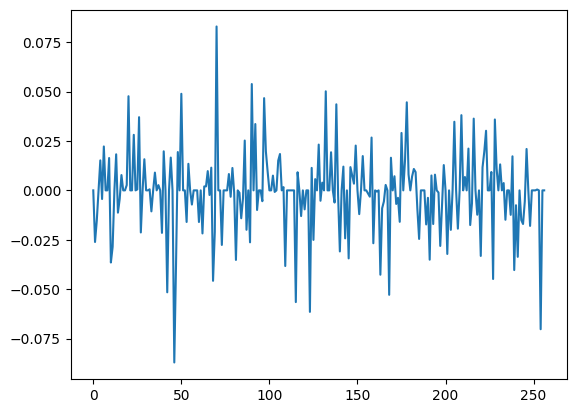

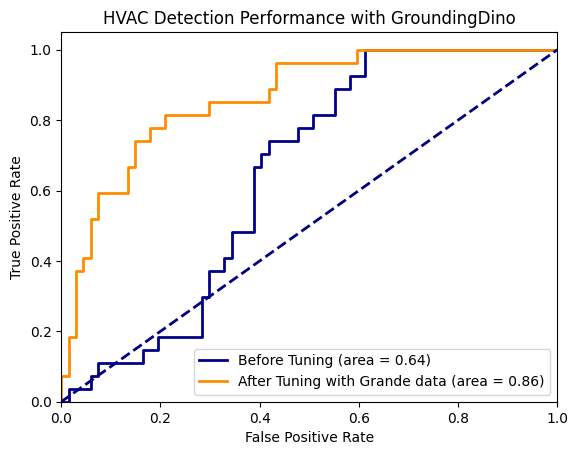

Grande Optimal Threshold:  0.24132772297174218
Zero Shot Optimal Threshold:  0.24132772297174218
Grande Model
0.7872340425531915
              precision    recall  f1-score   support

           0       0.90      0.79      0.84        67
           1       0.60      0.78      0.68        27

    accuracy                           0.79        94
   macro avg       0.75      0.78      0.76        94
weighted avg       0.81      0.79      0.79        94

[[53 14]
 [ 6 21]]
0.6774193548387096
Zero Shot Model
0.6382978723404256
              precision    recall  f1-score   support

           0       0.71      0.84      0.77        67
           1       0.27      0.15      0.19        27

    accuracy                           0.64        94
   macro avg       0.49      0.49      0.48        94
weighted avg       0.58      0.64      0.60        94

[[56 11]
 [23  4]]
0.5531914893617021


In [517]:
# Run linear regression to predict the matched column continuous based on the last_hidden_state_diff
df = zero_shot_df.copy(deep=True)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import fbeta_score

#X = np.array(train_df['top_states'].tolist())
#X = np.array(train_df['last_hidden_state'].tolist())

X = np.array(df['last_hidden_state'].tolist())
#X = np.array(df['scores'].tolist())
#add an intercept
X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)


y_iou = np.array(df['iou'])

import random
random.seed(42)
train_image_idx = random.sample(range(0,len(ds)), int(len(ds)*0.8))
test_image_idx = [x for x in range(0,len(ds)) if x not in train_image_idx]

train_idx = np.array(df[df['image_idx'].isin(train_image_idx)].index) 
test_idx = np.array(df[df['image_idx'].isin(test_image_idx)].index)


# test_idx = list(set(np.concatenate([test_idx,np.array([429, 430, 431, 432, 433, 434])])))
# train_idx = np.array([x for x in indicies if x not in test_idx])
X_train = X[train_idx]
X_test = X[test_idx]
y_iou_train = y_iou[train_idx]
y_iou_test = y_iou[test_idx]

scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)




df['matched'] = (df['iou'] > 0.33).astype(int)
y_matched = np.array(df['matched'])
y_matched_train = y_matched[train_idx]
y_matched_test = y_matched[test_idx]

y_orig_score = np.array(df['scores'])
y_orig_score_train = y_orig_score[train_idx]
y_orig_score_test = y_orig_score[test_idx]



#get coefficients for the lasso model to iou
clf = Lasso(alpha=0.001)
clf.fit(X_train, y_iou_train)
y_pred_iou = clf.predict(X_test)
#find and report coefficients
coefficients = clf.coef_
iou_pred_error = root_mean_squared_error(y_iou_test, y_pred_iou)
print("iou prediction error: " + str(iou_pred_error))
print("Number of non-zero coefficients: ", len(coefficients[coefficients != 0]))
plt.plot(coefficients)


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import root_mean_squared_error
fpr, tpr, thresholds = roc_curve(y_matched_test, y_pred_iou)
fpr_o, tpr_o, thresholds_o = roc_curve(y_matched_test, y_orig_score_test)
# beta = 1
# def find_optimal_threshold(y_true, y_scores,beta):
#     # Calculate the ROC curve points
#     fpr, tpr, thresholds = roc_curve(y_true, y_scores)
# 
#     # Calculate the F1 score for each threshold
#     f1_scores = [fbeta_score(y_true, y_scores > t, beta = beta) for t in thresholds]
# 
#     # Get the optimal threshold
#     optimal_idx = np.argmax(f1_scores)
#     optimal_threshold = thresholds[optimal_idx]
# 
#     return optimal_threshold
# optimal_threshold = find_optimal_threshold(y_matched_test, y_pred_iou,beta)
# optimal_threshold_o = find_optimal_threshold(y_matched_test, y_orig_score_test,beta)

roc_auc = auc(fpr, tpr)
roc_auc_o = auc(fpr_o, tpr_o)
plt.figure()
lw = 2

plt.plot(fpr_o, tpr_o, color='darkblue', lw=lw, label='Before Tuning (area = %0.2f)' % roc_auc_o)
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='After Tuning with Grande data (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('HVAC Detection Performance with GroundingDino')
plt.legend(loc="lower right")
plt.show()
#Compute the Youden's J statistic
J = tpr - fpr
J_o = tpr_o - fpr_o

# # Find the index of the threshold with the greatest Youden's J statistic
ix = np.argmax(J)
ix_o = np.argmax(J_o)

# Find the optimal threshold
optimal_threshold = thresholds[ix]
optimal_threshold_o = thresholds[ix]
print('Grande Optimal Threshold: ', optimal_threshold)
print('Zero Shot Optimal Threshold: ', optimal_threshold_o)


from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Grande Model")
y_pred_binary = (y_pred_iou > optimal_threshold).astype(int)
print(accuracy_score(y_matched_test, y_pred_binary))
print(classification_report(y_matched_test, y_pred_binary))
print(confusion_matrix(y_matched_test, y_pred_binary))
print(f1_scoring(y_matched_test, y_pred_iou))

print("Zero Shot Model")
y_orig_score_binary = (y_orig_score_test > optimal_threshold_o).astype(int)
print(accuracy_score(y_matched_test, y_orig_score_binary ))
print(classification_report(y_matched_test, y_orig_score_binary ))
print(confusion_matrix(y_matched_test, y_orig_score_binary ))
print(f1_scoring(y_matched_test, y_orig_score_test))

In [516]:
ix_o


34

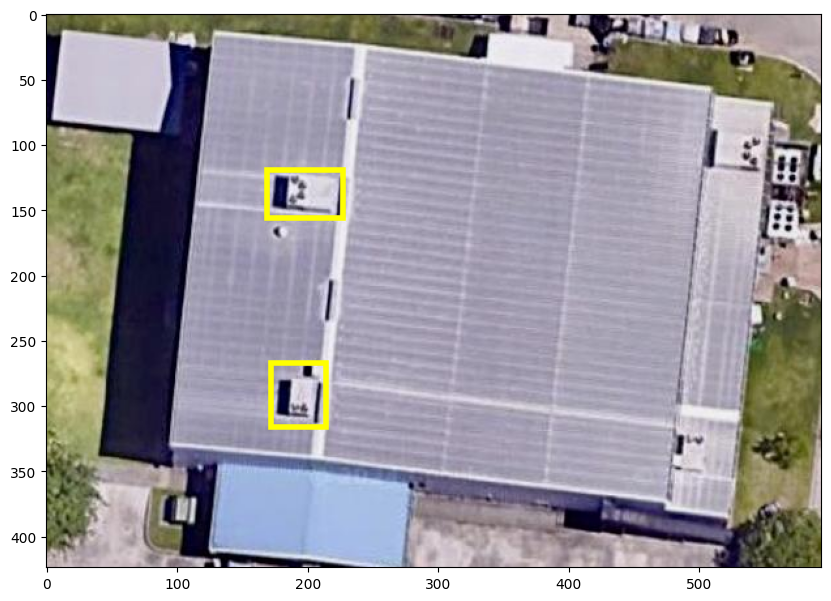

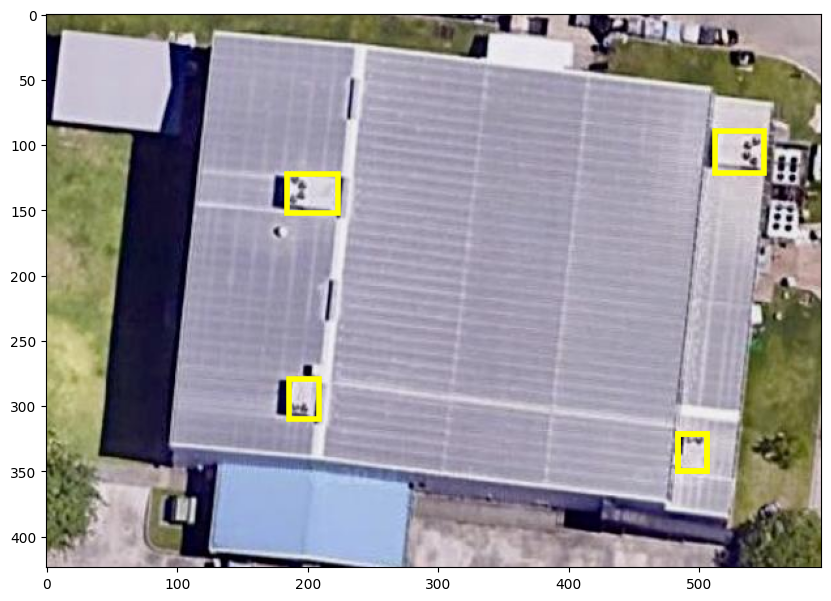

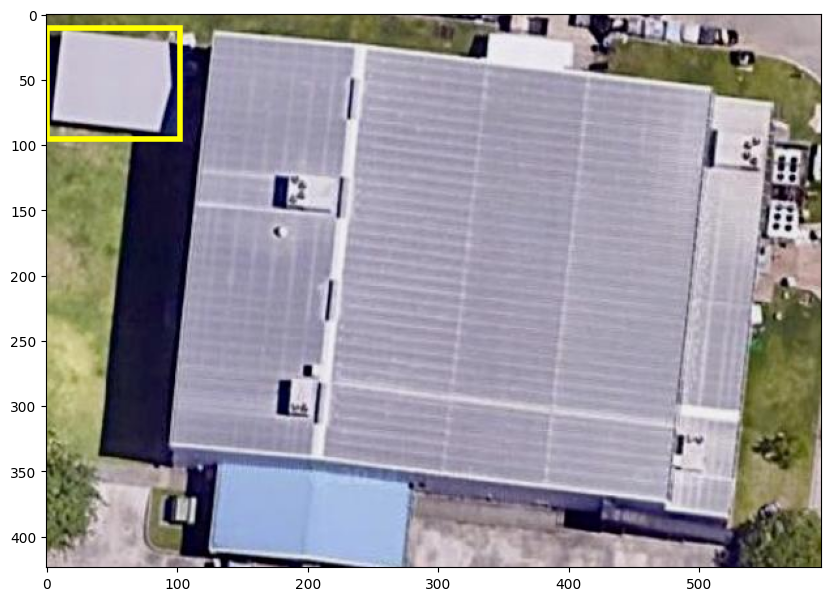

In [534]:

def spot_check_annotations(full_train, image_idx = 320, min_agreement = 80, zoom = False):
    patch_df = (full_train[(full_train['image_id'] == full_train['image_id'].iloc[image_idx])
                          & (full_train['percent_agreement'] >= min_agreement)])
    category = np.array(patch_df['name'])
    mask_geometry = patch_df['mask_geometry'].iloc[0]
    category_polygons = patch_df['averaged_polygons']
    image_path = patch_df['image_path'].iloc[0]
    display_image_with_mask(image_path, mask_geometry, category_polygons, category, zoom = zoom)

def convert_polygon_to_bbox(polygon):
    minx, miny, maxx, maxy = polygon.bounds
    width = maxx - minx
    height = maxy - miny
    return minx, miny, width, height


def display_image_with_mask(image_path, mask_geometry, category_polygons, category, zoom=False):
    # Load the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Display the image
    ax.imshow(image)
    

    if isinstance(category_polygons, Polygon):
        category_polygons= [category_polygons]


    if not zoom: # Display the mask
        x, y, width, height = convert_polygon_to_bbox(mask_geometry)
        patch = patches.Rectangle((x,y),width,height, edgecolor='green', facecolor='None',linewidth=2)
        ax.add_patch(patch)
    
    # Display the averaged polygons
    for cnt,polygon in enumerate(category_polygons):
        x, y, width, height = convert_polygon_to_bbox(polygon)
        if category[cnt] == 'AC Unit':
            color = 'green'
        elif category[cnt] == 'AC leaking':
            color = 'red'
        else:
            ValueError('Category not recognized')
            
        patch = patches.Rectangle((x,y),width,height, edgecolor=color, facecolor='None',linewidth=2)
        ax.add_patch(patch)
    
    if zoom:
        # Set the limits of the plot to the extent of the mask
        minx, miny, maxx, maxy = mask_geometry.bounds
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
        ax.grid(False)
    # Show the plot
    plt.show()


df = zero_shot_df.copy(deep=True)
df = df.iloc[test_idx,:]
df['new_scores'] = y_pred_iou
df['new_matched'] = (df['new_scores'] > optimal_threshold).astype(int)
df['orig_scores'] = y_orig_score_test
df['orig_matched'] = (df['orig_scores'] > optimal_threshold_o).astype(int)


image_idxs = [test_idx_image[0]]


for image_idx in image_idxs:
    patch_df = df[(df["image_idx"] == image_idx)].reset_index(drop=True)
    
    image = ds[image_idx]['image']

    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    
    new_patch = patch_df[patch_df['new_matched'] == 1]
    for idx in range(len(new_patch)):
        x1, y1, x2, y2 = new_patch['model_boxes'].iloc[idx]
        patch = patches.Rectangle((x1,y1),x2-x1,y2-y1, edgecolor='yellow', facecolor='None',linewidth=4)
        ax.add_patch(patch)

    
    # Display the image
    ax.imshow(image)
    
        # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    
    for idx in range(len(patch_df)):
        x1, y1, x2, y2 = patch_df['human_boxes'].iloc[idx]
        patch = patches.Rectangle((x1,y1),x2-x1,y2-y1, edgecolor='yellow', facecolor='None',linewidth=4)
        ax.add_patch(patch)

    
    # Display the image
    ax.imshow(image)
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    
    old_patch = patch_df[patch_df['orig_matched'] == 1]
    for idx in range(len(old_patch)):
        x1, y1, x2, y2 = old_patch['model_boxes'].iloc[idx]
        patch2 = patches.Rectangle((x1,y1),x2-x1,y2-y1, edgecolor='yellow', facecolor='None',linewidth=4)
        ax.add_patch(patch2)
    
    ax.imshow(image)

In [443]:
new_patch['model_boxes'].iloc[2]

[332, 12, 407, 45]

In [433]:
len(zero_shot_df)

587

In [428]:
patch_df['human_boxes'][3]

[484, 321, 506, 350]

In [ ]:
94E43BB7-9AB6-41C8-9D0D-4E5D5A1A1B4A

In [391]:
df = zero_shot_df.copy(deep=True)
df = df.iloc[test_idx]
df['new_scores'] = y_pred_iou
df['new_matched'] = (df['new_scores'] > optimal_threshold).astype(int)
df['orig_scores'] = y_orig_score_test
df['orig_matched'] = (df['orig_scores'] > optimal_threshold_o).astype(int)
image_idx = 106
df = df[df['image_idx'] == image_idx]


In [383]:
#drop duplicates in python list


In [370]:
(zero_shot_df[zero_shot_df['image_idx'] == 106].index)

[429, 430, 431, 432, 433, 434]

In [349]:
image_idx = 106
patch_df = zero_shot_df[(zero_shot_df["image_idx"] == image_idx)].reset_index(drop=True)

In [351]:
optimal_threshold

0.19500150422915308

In [350]:
patch_df

,annot_id,category,area,human_boxes,human_idx,tmp_key,model_boxes,scores,model_idx,image_idx,iou,last_hidden_state
0,279,0,7099,"[61, 253, 91, 277]",2,1,"[56, 240, 95, 280]",0.289912,0,106,0.472561,"[0.1592845618724823, -0.11963823437690735, -0...."
1,277,0,8184,"[55, 365, 86, 389]",0,1,"[51, 351, 90, 391]",0.272382,1,106,0.487805,"[0.1923404186964035, -0.13627289235591888, -0...."
2,278,0,6272,"[103, 122, 142, 146]",1,1,"[99, 109, 145, 150]",0.173698,2,106,0.506586,"[0.11397859454154968, -0.11671304702758789, -0..."
3,280,0,4464,"[104, 84, 136, 106]",3,1,"[100, 69, 144, 110]",0.142229,3,106,0.401587,"[0.22189706563949585, -0.09834569692611694, -0..."
4,278,0,6272,"[103, 122, 142, 146]",1,1,"[98, 68, 147, 151]",0.129411,4,106,0.238095,"[-0.14365187287330627, -0.16036686301231384, -..."
5,279,0,7099,"[61, 253, 91, 277]",2,1,"[83, 25, 129, 57]",0.114452,5,106,0.000000,"[-0.019241271540522575, -0.1624329835176468, -..."


In [162]:
new_model_new_hits = test_index[(y_matched_test == 1) &  (y_orig_score_binary == 0) & (y_pred_binary == 1)]
 
print(new_model_new_hits)


[651 179   5 340 410 890  51 303 958 859 528 917 902]


In [264]:
.81/1.9

0.42631578947368426

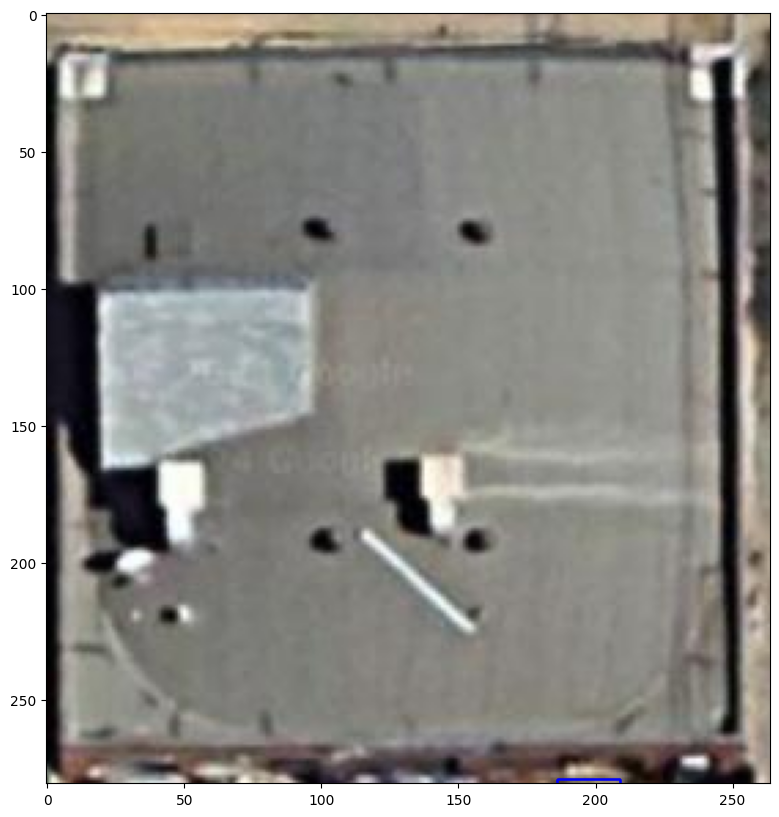

In [159]:
len(ds)

1140

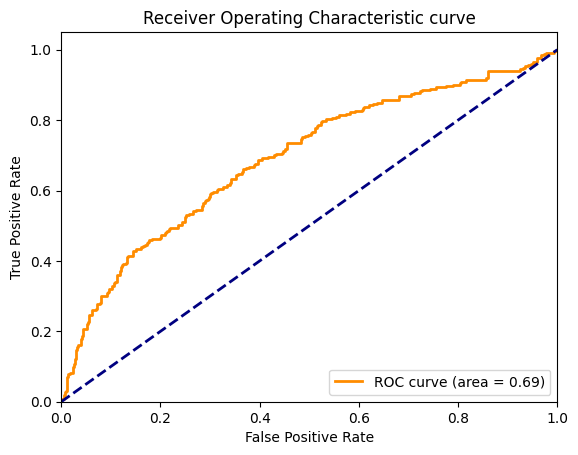

0.446071168211201
Optimal Threshold:  0.1585356444120407
Number of non-zero coefficients:  153


In [26]:

#measure the error of the model
from sklearn.metrics import mean_squared_error


#plot the AOC curve for the model as a function of threshold
from sklearn.metrics import roc_auc_score

y = df['matched']
y_pred = df['scores']
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import root_mean_squared_error
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2

plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.show()
# Compute the Youden's J statistic
J = tpr - fpr

# Find the index of the threshold with the greatest Youden's J statistic
ix = np.argmax(J)

# Find the optimal threshold
optimal_threshold = thresholds[ix]
print(root_mean_squared_error(y, y_pred))
print('Optimal Threshold: ', optimal_threshold)

#measure mae
from sklearn.metrics import mean_absolute_error
#mean_absolute_error(y_test, y_pred))



print("Number of non-zero coefficients: ", len(coefficients[coefficients != 0]))

In [109]:
# Run linear regression to predict the iou colummn continuous based on the last_hidden_state_diff
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

#X = np.array(train_df['top_states'].tolist())
#X = np.array(train_df['last_hidden_state'].tolist())

X = np.array(train_df['last_hidden_state'].tolist())
#add an intercept
X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
y = np.array(train_df['matched'])
scaler = StandardScaler()
X = scaler.fit_transform(X)
#set lasso model so that it can't predict less than 0
clf = Lasso(alpha=0.001)
clf.fit(X, y)
y_pred = clf.predict(X)
#y_pred[y_pred < 0] = 0
#find and report coefficients
coefficients = clf.coef_
plt.plot(coefficients)


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import root_mean_squared_error
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2

plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.show()
# Compute the Youden's J statistic
J = tpr - fpr

# Find the index of the threshold with the greatest Youden's J statistic
ix = np.argmax(J)

# Find the optimal threshold
optimal_threshold = thresholds[ix]
print(root_mean_squared_error(y, y_pred))
print('Optimal Threshold: ', optimal_threshold)

#measure mae
from sklearn.metrics import mean_absolute_error
#mean_absolute_error(y_test, y_pred))



print("Number of non-zero coefficients: ", len(coefficients[coefficients != 0]))


KeyError: 'matched'

In [98]:
train_test_split(X, y_iou, test_size=0.2, random_state=42)

[array([[-1.01807161,  0.79643261,  0.21810573, ...,  0.3118948 ,
          0.45884688,  0.        ],
        [-2.60897654, -3.56521006, -0.66393764, ...,  2.37696486,
         -0.65501637,  0.        ],
        [ 0.77162561, -0.19055147,  0.23851557, ..., -0.51037768,
          0.21149736,  0.        ],
        ...,
        [ 1.45451752, -0.43063717,  1.7576284 , ..., -1.22222508,
         -2.56248437,  0.        ],
        [-0.5724819 ,  0.79723696, -0.44420924, ...,  0.04239722,
          0.39477977,  0.        ],
        [-0.88248878,  0.27775493, -0.74175467, ...,  1.60807631,
          1.06655157,  0.        ]]),
 array([[ 1.08827439, -0.10386496,  0.20687091, ...,  0.1153009 ,
          0.03849361,  0.        ],
        [ 0.06285637, -0.0621471 ,  0.36255   , ...,  0.1711195 ,
         -0.19380876,  0.        ],
        [ 1.20235778,  0.31983338,  0.9666967 , ..., -0.8515244 ,
         -0.5822819 ,  0.        ],
        [ 0.09468297,  0.20922169, -0.45297353, ..., -0.03895998,
 

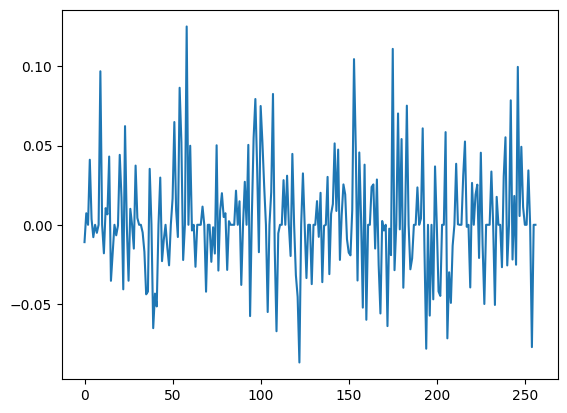

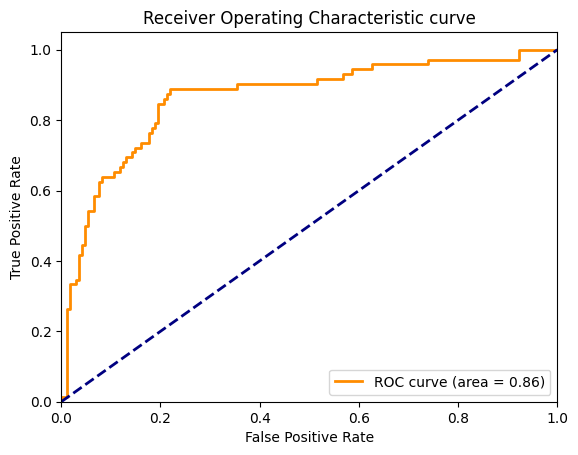

0.3831439120655797
Optimal Threshold:  0.3258390019468691
Number of non-zero coefficients:  187


In [33]:
# Run linear regression to predict the iou colummn continuous based on the last_hidden_state_diff
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error



X = np.array(test_df['last_hidden_state'].tolist())
#add an intercept
X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
y = np.array(test_df['matched'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

y_pred = clf.predict(X)

#find and report coefficients
coefficients = clf.coef_
plt.plot(coefficients)


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import root_mean_squared_error
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2

plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.show()
# Compute the Youden's J statistic
J = tpr - fpr

# Find the index of the threshold with the greatest Youden's J statistic
ix = np.argmax(J)

# Find the optimal threshold
optimal_threshold = thresholds[ix]
print(root_mean_squared_error(y, y_pred))
print('Optimal Threshold: ', optimal_threshold)



print("Number of non-zero coefficients: ", len(coefficients[coefficients != 0]))


In [29]:
y_pred

array([ 1.67117054e-01,  1.19153072e-01,  8.46116587e-01,  1.52113645e-01,
        5.52117388e-01,  2.91380626e-01,  2.18345178e-01,  2.51647206e-01,
        3.69382839e-01,  8.91597429e-01,  7.34951608e-01,  9.75817187e-01,
        1.15571069e-02,  4.48889564e-02,  3.80659397e-01,  7.11420326e-01,
        9.11547202e-01,  6.44038900e-01,  9.15591207e-01,  7.99038713e-01,
        1.35722746e-01,  8.38848356e-02,  2.21814087e-01,  1.95713352e-01,
       -2.27721979e-01,  1.74713130e-01, -6.62885574e-02, -7.33282823e-02,
        2.71849816e-01, -3.43263328e-02,  2.25755784e-02,  7.30404515e-01,
        7.72651622e-02,  5.82110267e-01,  3.15237623e-01, -2.64483355e-02,
        1.15828607e-01,  6.83145882e-01,  1.18415932e+00,  6.96162880e-01,
        1.05451874e+00,  1.02770864e-01,  7.38304490e-02, -1.37290848e-01,
        3.57536220e-03,  7.98993426e-01,  1.52877918e-01,  1.75059342e-01,
        3.64527597e-01,  2.02413433e-01,  3.27138510e-01, -5.48616050e-03,
        6.66666537e-01,  

In [30]:
#filter the GD Model results to reasonable boxes
def filter_model_bbox_outputs_rescore(results, outputs, image, params):
    params['area_threshold'] = 0.05

    width, height = image.size
    boxes = np.array(results[0]['boxes'].tolist())
    passing_area_idx = find_valid_boxes_by_area(boxes, width, height,params['area_threshold']
    )
    logits = outputs['logits'][0]
    probs = torch.sigmoid(logits)
    scores = np.array(torch.max(probs, dim=-1)[0].tolist())
    
    passing_score_idx = (scores > params['score_threshold']).astype(int)
    
    new_scores = []
    for cnt,lhs in enumerate(outputs.last_hidden_state.cpu().tolist()[0]):
        new_scores.append(np.sum(params['scalar'].transform(np.array(lhs + [1]).reshape(1,-1)) * params['coefficients']))
    
    new_passing_score_idx = (np.array(new_scores) > params['new_score_threshold']).astype(int)
    
    qualified_box_idx = find_indices(passing_area_idx & passing_score_idx & new_passing_score_idx, 1)
    
    skinny_filter = find_indices(remove_skinny_boxes(boxes[qualified_box_idx], threshold = params['skinny_threshold']),True)
    qualified_box_idx = [qualified_box_idx[i] for i in skinny_filter]
    
    overlap_filter = find_indices(remove_overlapping_boxes(boxes[qualified_box_idx], scores[qualified_box_idx], threshold = params['overlap_threshold']),True)
    qualified_box_idx = [qualified_box_idx[i] for i in overlap_filter]
    
    if params['display_image'] == True:
        labels = np.array(results[0]['labels'])
        category_bboxes = boxes[qualified_box_idx]
        cat_labels = ['AC Unit', 'AC leaking']
        category = ['AC Unit' for x in range(len(labels[qualified_box_idx]))]
        display_image_with_labels(image,category_bboxes, category)
    return qualified_box_idx

In [16]:
test_df2 = pd.DataFrame()
category_idx = 0
#for image_dict_idx in range(0, len(ds_dict['train'])): 
for image_dict_idx in range(0, len(ds_dict['test'])):

    human_labels = ds_dict['test'][image_dict_idx]['objects']
    image = ds_dict['test'][image_dict_idx]['image']
    with torch.no_grad():
        inputs = processor(images=image, text=text, return_tensors="pt").to(device)
    
        outputs = model(**inputs,output_hidden_states=True)
        results = processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            box_threshold=0.0,
            text_threshold=0.00,
            target_sizes=[image.size[::-1]],
    
        )
    params = {}
    params['scalar'] = scaler
    params['coefficients'] = coefficients
    params['display_image'] = False
    params['area_threshold'] = 0.05
    params['score_threshold'] = 0.1
    params['new_score_threshold'] = 0.05
    params['overlap_threshold'] = 0.5
    params['skinny_threshold'] = 0.33
    qualified_box_idx = filter_model_bbox_outputs_rescore(results, outputs, image, params)
    
    filt_outputs = FilteredOutputs()
    
    for output_items in ['logits', 'pred_boxes', 'last_hidden_state']:
        # filter the tensor's 2nd dimension by qualified_box_idx
        setattr(filt_outputs, output_items, outputs[output_items][:, qualified_box_idx, :])
    
    
    results_round2 = processor.post_process_grounded_object_detection(
        filt_outputs,
        inputs.input_ids,
        box_threshold=0.0,
        text_threshold=0.00,
        target_sizes=[image.size[::-1]],
    
    )

    boxes = results_round2[0]['boxes']
    scores = results_round2[0]['scores'].tolist()
    new_scores = []
    for cnt,lhs in enumerate(filt_outputs.last_hidden_state.cpu().tolist()[0]):
        new_scores.append(np.sum(scaler.transform(np.array(lhs + [1]).reshape(1,-1)) * coefficients))
    mdf = pd.DataFrame(columns = ['model_boxes'])
    mdf['model_boxes'] = [[int(y) for y in x] for x in boxes.tolist()]
    mdf['model_boxes'] = mdf['model_boxes']
    mdf['scores'] = scores
    mdf['new_scores'] = new_scores
    mdf['model_idx'] = mdf.index
    mdf['tmp_key'] = 1
    no_candidates = False
    if len(mdf) == 0:
        no_candidates = True
        mdf = pd.DataFrame({'model_boxes': [[0,0,0,0]], 'scores': [0], 'new_scores': [0], 'model_idx': [0], 'tmp_key': [1]})

    
    hdf = human_labels_to_df(human_labels, category_idx)
    hdf['human_idx'] = hdf.index
    hdf['tmp_key'] = 1
    annot_df = pd.merge(hdf,mdf, on='tmp_key')
    if no_candidates == False:
        annot_df['iou'] = annot_df.apply(lambda row: calculate_iou_not_polygon(row['human_boxes'], row['model_boxes']), axis=1)
        best_match_df = annot_df.sort_values('iou', ascending=False).drop_duplicates(['model_boxes']).sort_values('model_idx')
    
        best_match_df['last_hidden_state'] = filt_outputs.last_hidden_state.cpu().tolist()[0]
        logits = filt_outputs.logits.cpu().numpy()[0]
        logits = list(logits[:, (logits != float('-inf')).any(axis=0)])
        best_match_df['logits'] = logits
    else:
        best_match_df = annot_df
        best_match_df['iou'] = np.nan
        best_match_df['model_idx'] = np.nan
        best_match_df['last_hidden_state'] = np.nan
        best_match_df['logits'] = np.nan
        
        
    test_df2 = pd.concat([test_df2,best_match_df], ignore_index=True)
    print(str(image_dict_idx) + ' ' + 'for category_idx ' + str(category_idx) + ' processed')


KeyboardInterrupt



In [ ]:
test_df2.to_pickle('../data/models/ac_model/test_df2.pkl')

In [373]:
# load test_df2 from disk
test_df2 = pd.read_pickle('../data/models/ac_model/test_df2.pkl')


In [374]:
# Run RFC to predict the matched column based on the last_hidden_state_diff
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


test_df2['iou'] = test_df2['iou'].fillna(0)

test_df2['matched'] = (test_df2['iou'] > 0).astype(int)
test_df2['predicted'] = (test_df2['new_scores'] > 0.1).astype(int)
y_test = np.array(test_df2['matched'].tolist())
y_pred = np.array(test_df2['predicted'].tolist()).reshape(-1,1)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.7473684210526316
              precision    recall  f1-score   support

           0       0.74      0.49      0.59        35
           1       0.75      0.90      0.82        60

    accuracy                           0.75        95
   macro avg       0.74      0.69      0.70        95
weighted avg       0.75      0.75      0.73        95

[[17 18]
 [ 6 54]]


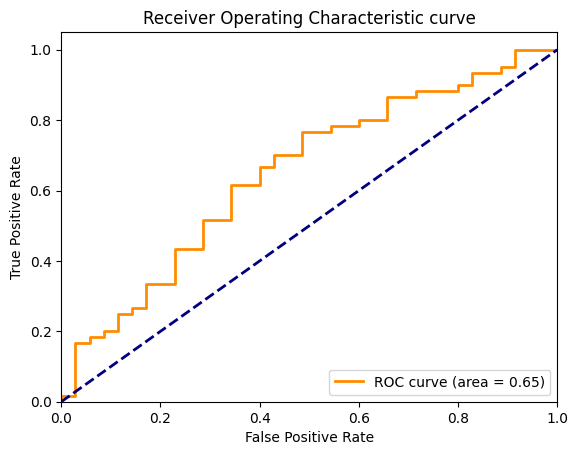

Optimal Threshold:  0.15024255216121674


In [379]:
y = test_df2['matched']
y_pred = test_df2['scores']
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2



plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.show()


# Compute the Youden's J statistic
J = tpr - fpr

# Find the index of the threshold with the greatest Youden's J statistic
ix = np.argmax(J)

# Find the optimal threshold
optimal_threshold = thresholds[ix]

print('Optimal Threshold: ', optimal_threshold)

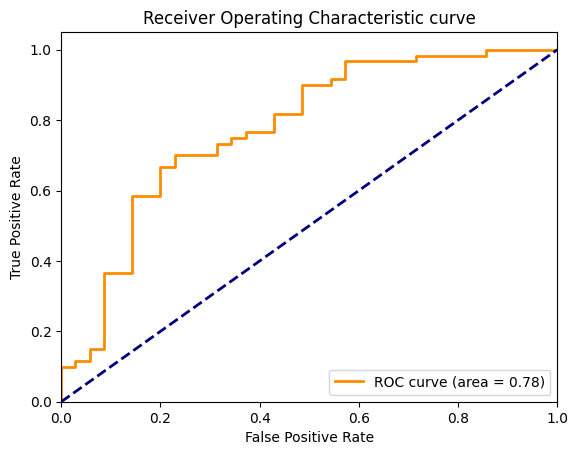

In [376]:
y = test_df2['matched']
y_pred = test_df2['new_scores']
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2



plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [354]:
test_df2

,annot_id,category,area,human_boxes,human_idx,tmp_key,model_boxes,scores,new_scores,model_idx,iou,last_hidden_state,logits,matched,predicted
0,217,0,1610,"[57, 69, 79, 92]",0,1,"[56, 67, 80, 94]",0.231921,0.487448,0.0,0.788571,"[-0.05715395510196686, -0.10921353101730347, -0.23560108244419098, -0.36804911494255066, -0.10899964720010757, 0.22735440731048584, 0.04868728667497635, 0.0584968701004982, 0.28069284558296204, -0.037344954907894135, -0.3260784149169922, 0.38047415018081665, 0.014420226216316223, -0.05241736024618149, 0.06341203302145004, -0.10664917528629303, -0.3599342107772827, 0.03260357677936554, -0.2657545506954193, 0.022429876029491425, -0.12035149335861206, 0.11174235492944717, 0.13286349177360535, 0.18808609247207642, -0.2159712314605713, -0.06882388144731522, -0.05292310565710068, -0.20606540143489838, -0.002350442111492157, -0.30520740151405334, -0.009150132536888123, 0.043087586760520935, 0.17256245017051697, 0.02554462105035782, -0.28868743777275085, -0.10002397745847702, -0.19029811024665833, -0.48751676082611084, -0.11344277858734131, -0.2876327633857727, -0.22231733798980713, -0.3299804925918579, 0.07768482714891434, 0.11874698102474213, -0.00946858525276184, -0.12019073963165283, -0.037912845611572266, -0.126487135887146, -0.3207019865512848, -0.3922276496887207, -0.0548861101269722, -0.15037567913532257, -0.41057994961738586, -0.11653237044811249, -0.3923470079898834, -0.0643845945596695, 0.18544147908687592, -0.34114140272140503, -0.5481634736061096, 0.20494288206100464, 0.1398821771144867, -0.2972184419631958, -0.20502969622612, -0.3624832034111023, 0.4085160791873932, -0.3258857727050781, 0.048521146178245544, 0.020913556218147278, 0.08648598194122314, -0.15582053363323212, -0.26091325283050537, -0.1351647824048996, 0.12943881750106812, -0.21311050653457642, -0.16769355535507202, -0.3539266288280487, -0.3827139735221863, 0.0173400416970253, 0.2865010201931, 0.0026990771293640137, -0.08231791853904724, -0.49435660243034363, -0.22911326587200165, 2.665419578552246, -0.5229977369308472, 0.18651746213436127, -0.18178728222846985, -0.14085358381271362, -0.25068241357803345, -0.008328475058078766, 0.3170923888683319, 0.05866926163434982, -0.15268389880657196, -0.13844676315784454, 0.0748348981142044, -0.09213712811470032, -0.12659387290477753, -0.02629151940345764, 0.08557415008544922, -0.24503956735134125, ...]","[-5.047874, -1.1974951, -1.298797, -1.2713541, -1.3057112, -4.2388506, -2.4032674, -2.3571055, -2.2023742, -3.037864, -1.7506242, -4.8293195, -5.238943, -5.16621, -5.4877853, -4.4298778, -3.6928515, -5.290555, -3.2582278, -1.8415267, -1.8295058, -1.9080074, -1.8537563, -1.7377644, -4.118514, -5.038136]",1,1
1,216,0,11926,"[95, 211, 123, 244]",1,1,"[84, 211, 126, 247]",0.199287,0.265817,0.0,0.619736,"[-0.136999249458313, -0.11686422675848007, -0.13964802026748657, -0.35494711995124817, -0.016169779002666473, 0.10786323994398117, 0.04785488545894623, -0.195937842130661, 0.13531187176704407, 0.007929868996143341, -0.29305583238601685, 0.45123377442359924, -0.051529332995414734, -0.03630613535642624, -0.10354568064212799, -0.21661123633384705, -0.31707799434661865, -0.05194418877363205, -0.15281382203102112, -0.06880148500204086, -0.15284395217895508, 0.1760445535182953, 0.1490161418914795, 0.01892852783203125, -0.23354601860046387, -0.016020596027374268, -0.006009489297866821, -0.19979143142700195, -0.17348766326904297, -0.22993087768554688, 0.03036601096391678, 0.08567468822002411, 0.1476917564868927, -0.025897469371557236, -0.3245031237602234, -0.18205691874027252, -0.27051621675491333, -0.48442885279655457, -0.12373995780944824, -0.21660785377025604, -0.13522428274154663, -0.08864302188158035, 0.03861293941736221, 0.03671461343765259, -0.1764291226863861, -0.13906365633010864, -0.06721936911344528, -0.1249367892742157, -0.17799368500709534, -0.20798221230506897, -0.10674242675304413, -0.10004843771457672, -0.3503645956516266, -0.14070667326450348, -0.28753724694252014, 0.16686247289180756, 0.163

In [290]:
len(filt_outputs.last_hidden_state.cpu().tolist()[0])

1

<Axes: >

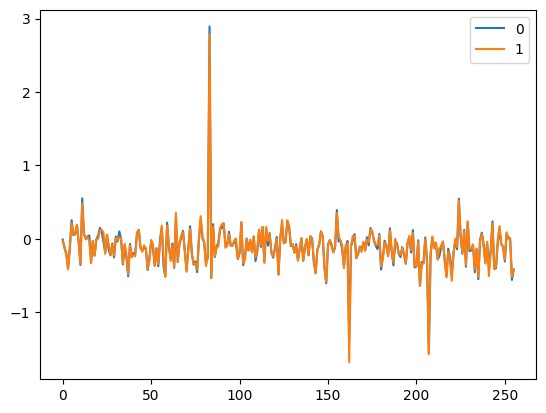

In [39]:
tmp = train_df.iloc[:].groupby(['matched'])['last_hidden_state'].apply(lambda x: np.mean(np.array(x.tolist()), axis=0))
pd.DataFrame(np.array([np.array(x) for x in tmp.values]).T)
pd.DataFrame(np.array([np.array(x) for x in tmp.values]).T).plot(kind='line')

<Axes: >

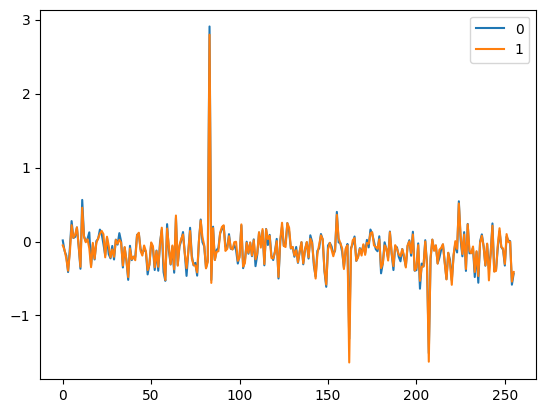

In [40]:
tmp = train_df.iloc[200:300].groupby(['matched'])['last_hidden_state'].apply(lambda x: np.mean(np.array(x.tolist()), axis=0))
pd.DataFrame(np.array([np.array(x) for x in tmp.values]).T).plot(kind='line')

In [ ]:
# abs_top = np.abs(train_df.loc[:,'last_hidden_state'].mean(axis = 0))
# # get the index of the sorted absolut values
# abs_top_idx = np.argsort(abs_top)
# train_df['top_states'] = train_df['last_hidden_state'].apply(lambda x: x[abs_top_idx[0:250]])

In [207]:
# Run RFC to predict the matched column based on the last_hidden_state_diff
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

X = np.array(train_df['last_hidden_state'].tolist())
#X = np.array(train_df['scores']).reshape(-1,1)
y = np.array(train_df['matched'].tolist())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred = np.round(y_pred)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


0.8461538461538461
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       130
           1       0.82      0.60      0.69        52

    accuracy                           0.85       182
   macro avg       0.83      0.77      0.79       182
weighted avg       0.84      0.85      0.84       182

[[123   7]
 [ 21  31]]


array([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0])

In [252]:
# Run random forest regression to predict the iou colummn continuous based on the last_hidden_state_diff
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


X = np.array(train_df['last_hidden_state'].tolist())
y = np.array(train_df['iou'].tolist())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf = RandomForestRegressor()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

#measure the error of the model


from sklearn.metrics import root_mean_squared_error
print(root_mean_squared_error(y_test, y_pred))








0.17185818229258376


In [254]:
# Run RFC to predict the matched column based on the last_hidden_state_diff
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

X = np.array(train_df['last_hidden_state'].tolist())
#X = train_df[['logits_score']]
#X = np.array(train_df['scores']).reshape(-1,1)
#X = np.concatenate([np.array(train_df['last_hidden_state'].tolist()),train_df['scores'].values.reshape(-1,1)],1)
y = np.array(train_df['matched'].tolist())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
#y_pred = np.round(y_pred)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.8406593406593407
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       130
           1       0.85      0.54      0.66        52

    accuracy                           0.84       182
   macro avg       0.84      0.75      0.78       182
weighted avg       0.84      0.84      0.83       182

[[125   5]
 [ 24  28]]


In [197]:
y_pred

array([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0])

/var/folders/2v/5ynl9w294pd7vyqtmlmp694r0000gn/T/ipykernel_81516/725016053.py:3: RuntimeWarning: Mean of empty slice.
  matched_scaled = X_train[y_train == 1].mean(axis=0)
/Users/jkerlin/PycharmProjects/satana/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


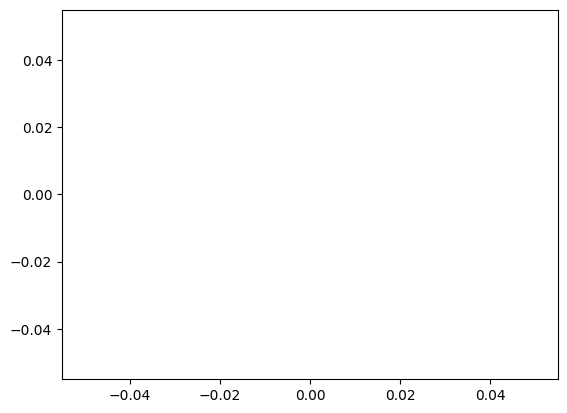

In [69]:
import matplotlib.pyplot as plt
#find the mean of X_train where y = 1
matched_scaled = X_train[y_train == 1].mean(axis=0)
non_matched_scaled = X_train[y_train == 0].mean(axis=0)

plt.figure()

plt.plot(matched_scaled)
#plt.plot(non_matched_scaled)

In [ ]:
plt.imshow(non_matched_scaled.reshape(16,16))

In [ ]:
X

In [331]:
train_df.iou.mean()


0.1198163055785481

In [260]:
train_df['prediction']

0      0.005462
1     -0.094943
2      0.182579
3     -0.011011
4      0.175999
         ...   
902    0.100653
903    0.148996
904    0.012451
905    0.091748
906    0.209457
Name: prediction, Length: 907, dtype: float64

In [233]:
clf

Lasso(alpha=0.001)

In [268]:
train_df['logits_score'] = train_df['logits'].apply(lambda x: np.sum(x))

In [323]:
train_df[['iou', 'scores','prediction','logits_score']].corr()

,iou,scores,prediction,logits_score
iou,1.000000,0.373012,0.754698,0.288580
scores,0.373012,1.000000,0.498894,0.723928
prediction,0.754698,0.498894,1.000000,0.389679
logits_score,0.288580,0.723928,0.389679,1.000000


In [329]:
test_df2[['iou', 'new_scores','scores']].corr()

,iou,new_scores,scores
iou,1.000000,0.381952,0.128269
new_scores,0.381952,1.000000,0.379937
scores,0.128269,0.379937,1.000000


In [ ]:
pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}).plot()
print(pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}).corr())

In [ ]:
pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}).plot()
print(pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}).corr())

In [ ]:

for output_items in outputs.keys():
    #if output_items is not a tuple, print the shape
    if not isinstance(outputs[output_items], tuple):
        print(output_items + ' ' + str(outputs[output_items].shape))
    else:
        print(str(outputs[output_items][0].shape) + ' ' + str(outputs[output_items][1].shape))


In [ ]:
from transformers.image_transforms import center_to_corners_format
def convert_box_format(tensor_norm_boxes,img_w, img_h):
    boxes = center_to_corners_format(tensor_norm_boxes)
    return boxes

In [ ]:

human_labels

In [ ]:
human_labels_to_df(human_labels, 0)

In [ ]:
boxes.tolist()

In [ ]:
mdf

In [ ]:
annot_df

In [ ]:
filt_outputs.logits.cpu()

In [ ]:
Polygon(list(category_bboxes[0].astype(int)))

In [ ]:
list(category_bboxes[0])

In [ ]:
outputs.keys()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(decoder[0])


In [ ]:
outputs['pred_boxes'].shape

In [ ]:
# find the area of each box in the image from the results and compare to the size of the image. If the box is too large, it is likely a false positive. Threshold for the area can be set. filter all fields in results[0] if the threshold is not met.

def filter_by_boxes(results, image):
    width, height = image.size
    filtered_boxes = []
    filtered_scores = []
    filtered_labels = []
    for i in range(len(results[0]['boxes'])):
        box = results[0]['boxes'][i]
        area = (box[2] - box[0]) * (box[3] - box[1])
        if area < width * height * 0.05:
            filtered_boxes.append(box)
            filtered_scores.append(float(results[0]['scores'][i]))
            filtered_labels.append(str(results[0]['labels'][i]))
    if len(filtered_boxes) > 0:
        filtered_results = [{'boxes': torch.stack(filtered_boxes), 'scores': torch.tensor(filtered_scores), 'labels': filtered_labels}]
    else:
        filtered_results = [{'boxes': torch.tensor([]), 'scores': torch.tensor([]), 'labels': []}]
    return filtered_results


In [ ]:

#image = ds[22]['image']

#text = "a small HVAC machine on a roof of a building, which usually appears as a white or gray box with one or a few darker, circular fans on top that look like dots." #(word 'machine' helps on ds[13]['image']"" )

#text = "a small HVAC (air conditioner) unit on a roof, white or gray box with a dark, circular fan dot." #("winner on  ds[3]['image']")

#text = "a tiny HVAC (air conditioner) unit that MUST be ON a roof." #(winner on ds[8]['image'], overconfident on ds[10]['image'])

text = "a tiny HVAC (air conditioner) machine that MUST be ON a roof." #(word 'machine' helps on ds[16]['image'])
#text = "robot eyes"

result_set = [None] * len(ds)
for cnt in range(0, 150):
    image = ds[cnt]['image']
    with torch.no_grad():
        inputs = processor(images=image, text=text, return_tensors="pt").to(device)

        outputs = model(**inputs)
        results = processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            box_threshold=0.3,
            text_threshold=0.00,
            target_sizes=[image.size[::-1]],

        )
        #results = filter_by_boxes(results, image)
        result_set[cnt] = results
        for score, label, box in zip(results[0]["scores"], results[0]["labels"], results[0]["boxes"]):
            box = [round(i, 2) for i in box.tolist()]
            print(
                f"Detected  '" + label + "' with confidence "
                f"{round(score.item(), 3)} at location {box}"
            )
        print(str(cnt) + ' ' + 'processed')

In [ ]:
#save the results to a file
# import pickle
# with open('../data/models/ac_model/ac_detect_a_tiny_hvac_thresh_p3' + '.pkl', 'wb') as f:
#     pickle.dump(result_set, f)

In [ ]:
last_hidden_states = outputs.last_hidden_state_vision

In [ ]:
last_hidden_states.shape

GroundingDinoModel

class transformers.GroundingDinoModel
<
source
>
( config: GroundingDinoConfig )

Parameters

config (GroundingDinoConfig) — Model configuration class with all the parameters of the model. Initializing with a config file does not load the weights associated with the model, only the configuration. Check out the from_pretrained() method to load the model weights.
The bare Grounding DINO Model (consisting of a backbone and encoder-decoder Transformer) outputting raw hidden-states without any specific head on top.

This model inherits from PreTrainedModel. Check the superclass documentation for the generic methods the library implements for all its model (such as downloading or saving, resizing the input embeddings, pruning heads etc.)

This model is also a PyTorch torch.nn.Module subclass. Use it as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to general usage and behavior.

forward
<
source
>
( pixel_values: Tensorinput_ids: Tensortoken_type_ids: Optional = Noneattention_mask: Optional = Nonepixel_mask: Optional = Noneencoder_outputs = Noneoutput_attentions = Noneoutput_hidden_states = Nonereturn_dict = None ) → transformers.models.grounding_dino.modeling_grounding_dino.GroundingDinoModelOutput or tuple(torch.FloatTensor)

Parameters

pixel_values (torch.FloatTensor of shape (batch_size, num_channels, height, width)) — Pixel values. Padding will be ignored by default should you provide it.
Pixel values can be obtained using AutoImageProcessor. See GroundingDinoImageProcessor.call() for details.

input_ids (torch.LongTensor of shape (batch_size, text_sequence_length)) — Indices of input sequence tokens in the vocabulary. Padding will be ignored by default should you provide it.
Indices can be obtained using AutoTokenizer. See GroundingDinoTokenizer.__call__ for details.

token_type_ids (torch.LongTensor of shape (batch_size, text_sequence_length), optional) — Segment token indices to indicate first and second portions of the inputs. Indices are selected in [0, 1]: 0 corresponds to a sentence A token, 1 corresponds to a sentence B token
What are token type IDs?

attention_mask (torch.LongTensor of shape (batch_size, text_sequence_length), optional) — Mask to avoid performing attention on padding token indices. Mask values selected in [0, 1]:
1 for tokens that are real (i.e. not masked),
0 for tokens that are padding (i.e. masked).
What are attention masks?

pixel_mask (torch.LongTensor of shape (batch_size, height, width), optional) — Mask to avoid performing attention on padding pixel values. Mask values selected in [0, 1]:
1 for pixels that are real (i.e. not masked),
0 for pixels that are padding (i.e. masked).
What are attention masks?

encoder_outputs (tuple(tuple(torch.FloatTensor), optional) — Tuple consists of (last_hidden_state_vision, optional: last_hidden_state_text, optional: vision_hidden_states, optional: text_hidden_states, optional: attentions) last_hidden_state_vision of shape (batch_size, sequence_length, hidden_size), optional) is a sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention of the decoder.

output_attentions (bool, optional) — Whether or not to return the attentions tensors of all attention layers. See attentions under returned tensors for more detail.

output_hidden_states (bool, optional) — Whether or not to return the hidden states of all layers. See hidden_states under returned tensors for more detail.

return_dict (bool, optional) — Whether or not to return a ModelOutput instead of a plain tuple.
Returns

transformers.models.grounding_dino.modeling_grounding_dino.GroundingDinoModelOutput or tuple(torch.FloatTensor)

A transformers.models.grounding_dino.modeling_grounding_dino.GroundingDinoModelOutput or a tuple of torch.FloatTensor (if return_dict=False is passed or when config.return_dict=False) comprising various elements depending on the configuration (GroundingDinoConfig) and inputs.

last_hidden_state (torch.FloatTensor of shape (batch_size, num_queries, hidden_size)) — Sequence of hidden-states at the output of the last layer of the decoder of the model.
init_reference_points (torch.FloatTensor of shape (batch_size, num_queries, 4)) — Initial reference points sent through the Transformer decoder.
intermediate_hidden_states (torch.FloatTensor of shape (batch_size, config.decoder_layers, num_queries, hidden_size)) — Stacked intermediate hidden states (output of each layer of the decoder).
intermediate_reference_points (torch.FloatTensor of shape (batch_size, config.decoder_layers, num_queries, 4)) — Stacked intermediate reference points (reference points of each layer of the decoder).
decoder_hidden_states (tuple(torch.FloatTensor), optional, returned when output_hidden_states=True is passed or when config.output_hidden_states=True) — Tuple of torch.FloatTensor (one for the output of the embeddings + one for the output of each layer) of shape (batch_size, num_queries, hidden_size). Hidden-states of the decoder at the output of each layer plus the initial embedding outputs.
decoder_attentions (tuple(tuple(torch.FloatTensor)), optional, returned when output_attentions=True is passed or when config.output_attentions=True) — Tuple of tuples of torch.FloatTensor (one for attention for each layer) of shape (batch_size, num_heads, sequence_length, sequence_length). Attentions weights after the attention softmax, used to compute the weighted average in the self-attention, cross-attention and multi-scale deformable attention heads.
encoder_last_hidden_state_vision (torch.FloatTensor of shape (batch_size, sequence_length, hidden_size), optional) — Sequence of hidden-states at the output of the last layer of the encoder of the model.
encoder_last_hidden_state_text (torch.FloatTensor of shape (batch_size, sequence_length, hidden_size), optional) — Sequence of hidden-states at the output of the last layer of the encoder of the model.
encoder_vision_hidden_states (tuple(torch.FloatTensor), optional, returned when output_hidden_states=True is passed or when config.output_hidden_states=True) — Tuple of torch.FloatTensor (one for the output of the vision embeddings + one for the output of each layer) of shape (batch_size, sequence_length, hidden_size). Hidden-states of the vision encoder at the output of each layer plus the initial embedding outputs.
encoder_text_hidden_states (tuple(torch.FloatTensor), optional, returned when output_hidden_states=True is passed or when config.output_hidden_states=True) — Tuple of torch.FloatTensor (one for the output of the text embeddings + one for the output of each layer) of shape (batch_size, sequence_length, hidden_size). Hidden-states of the text encoder at the output of each layer plus the initial embedding outputs.
encoder_attentions (tuple(tuple(torch.FloatTensor)), optional, returned when output_attentions=True is passed or when config.output_attentions=True) — Tuple of tuples of torch.FloatTensor (one for attention for each layer) of shape (batch_size, num_heads, sequence_length, sequence_length). Attentions weights after the attention softmax, used to compute the weighted average in the text-vision attention, vision-text attention, text-enhancer (self-attention) and multi-scale deformable attention heads. attention softmax, used to compute the weighted average in the bi-attention heads.
enc_outputs_class (torch.FloatTensor of shape (batch_size, sequence_length, config.num_labels), optional, returned when config.two_stage=True) — Predicted bounding boxes scores where the top config.num_queries scoring bounding boxes are picked as region proposals in the first stage. Output of bounding box binary classification (i.e. foreground and background).
enc_outputs_coord_logits (torch.FloatTensor of shape (batch_size, sequence_length, 4), optional, returned when config.two_stage=True) — Logits of predicted bounding boxes coordinates in the first stage.
The GroundingDinoModel forward method, overrides the __call__ special method.

Although the recipe for forward pass needs to be defined within this function, one should call the Module instance afterwards instead of this since the former takes care of running the pre and post processing steps while the latter silently ignores them.

Examples:

Copied
from transformers import AutoProcessor, AutoModel
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
text = "a cat."

processor = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-tiny")
model = AutoModel.from_pretrained("IDEA-Research/grounding-dino-tiny")

inputs = processor(images=image, text=text, return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
list(last_hidden_states.shape)
[1, 900, 256]

In [ ]:
# plt.imshow()
outputs.keys()
logits = outputs['logits'][0].detach().cpu()
#squeeze out -inf columns from logits tensor
logits = logits[:, (logits != float('-inf')).any(dim=0)]
decoder = outputs['decoder_hidden_states'][0].detach().cpu()
#decoder = decoder[:, (decoder != float('-inf')).any(dim=0)]

In [ ]:
#get the last hidden layer from the visual component of the HuggingFace GroundingDino model



In [ ]:
import torchvision
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import transforms

for cnt in range(0, 150):
    if len(result_set[cnt][0]['scores']) > 0:
        results = filter_by_boxes(result_set[cnt], image)
        if len(results[0]['scores']) > 0:
            for score, label, box in zip(results[0]["scores"], results[0]["labels"], results[0]["boxes"]):
                box = [round(i, 2) for i in box.tolist()]
                print(
                    f"Detected  '" + label + "' with confidence "
                    f"{round(score.item(), 3)} at location {box}"
                )


    show_example = True
    if show_example == True:
        tensor_boxes = results[0]["boxes"]
        image = ds[cnt]['image']
        tensor_image = transforms.ToTensor()(image)
        # Convert the Tensor back to uint8
        tensor_image = tensor_image.mul(255).byte()
    if len(results[0]['scores']) > 0:
        bbox_img = draw_bounding_boxes(tensor_image, tensor_boxes, width = 3, colors = "red")
        bbox_img = torchvision.transforms.ToPILImage()(bbox_img)

        bbox_img.show()

In [ ]:

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.25,
    text_threshold=0.00,
    target_sizes=[image.size[::-1]],

)
results = filter_by_boxes(results, image)

for score, label, box in zip(results[0]["scores"], results[0]["labels"], results[0]["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected  '" + label + "' with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )




import torchvision
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import transforms

show_example = True
if show_example == True:
    tensor_boxes = results[0]["boxes"]

    tensor_image = transforms.ToTensor()(image)
    # Convert the Tensor back to uint8
    tensor_image = tensor_image.mul(255).byte()

    bbox_img = draw_bounding_boxes(tensor_image, tensor_boxes, width = 3, colors = "red")
    bbox_img = torchvision.transforms.ToPILImage()(bbox_img)

    bbox_img.show()

In [ ]:
results


In [ ]:
results

In [ ]:
filtered_boxes

In [ ]:
results[0]['labels']

In [ ]:


import torchvision
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import transforms

show_example = True
if show_example == True:
    tensor_boxes = torch.tensor(results[0]["boxes"]) 
    
    tensor_image = transforms.ToTensor()(image)
    # Convert the Tensor back to uint8
    tensor_image = tensor_image.mul(255).byte()
    
    bbox_img = draw_bounding_boxes(tensor_image, tensor_boxes, width = 3, colors = "red")
    bbox_img = torchvision.transforms.ToPILImage()(bbox_img)
    
    bbox_img.show()

In [ ]:
pd.DataFrame(hf_ds).iloc[2]['image']

In [ ]:
import datasets
dir(PIL.Image)

In [ ]:
hf_ds[1]['image']

In [ ]:
#convert hf_ds json list to a pyarrow dataset
import pyarrow as pa
import pyarrow.dataset as ds
def gen(hf_ds):
    for i in hf_ds:
        yield i

ds = Dataset.from_generator(gen(hf_ds))





In [ ]:
([int(mask_df[mask_df['image_id'] == row]['x']), 
 int(mask_df[mask_df['image_id'] == row]['y']), 
 int(mask_df[mask_df['image_id'] == row]['w']), 
 int(mask_df[mask_df['image_id'] == row]['h']])

In [ ]:
# Convert my full_training set into a HuggingFace dataset for object detection in a format that works with groundingdino

from PIL import Image

def convert_to_hf_dataset(bbox_df):
    from datasets import Dataset
    from PIL import Image
    data

    
{
  'image_id': 366,
  'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=500x290>,
  'width': 500,
  'height': 500,
  'objects': {
    'id': [1932, 1933, 1934],
    'area': [27063, 34200, 32431],
    'bbox': [[29.0, 11.0, 97.0, 279.0],
      [201.0, 1.0, 120.0, 285.0],
      [382.0, 0.0, 113.0, 287.0]],
    'category': [0, 0, 0]
  }
}

In [ ]:
from datasets import Dataset
from PIL import Image

hf_ds = Dataset.from_pandas(full_train)

In [ ]:
np.array(mask_geometry[0].exterior)

In [ ]:
#May be greater than 100 you have intersecting sets, need to resolve with filter
agree_bin = matched_sets.groupby(['name','percent_agreement']).size().rename('count').reset_index().join(matched_sets.groupby(['name']).size().rename('total'), on = 'name')
agree_bin['percent_total'] = agree_bin['count']/agree_bin['total']*100
print(agree_bin)


In [ ]:
#matched_sets.copy(deep = True)

In [ ]:
len(label_set)

In [ ]:
filt_connected_sets = matched_sets[matched_sets['num_agree_in_set'] >= 3]


In [ ]:
min_matches_per_image = 3

worker_has_polygon = df[['image_id', 'name', 'worker']].drop_duplicates()
worker_has_polygon['ind_worker_label'] = int(1)
worker_has_polygon['cross_join'] = 1

#labeler_df = connected_sets.copy(deep = True)
labeler_df = matched_sets[matched_sets['num_agree_in_set'] >= min_matches_per_image]
labeler_df = labeler_df[['image_id','name']].drop_duplicates()
comp_to_prime = labeler_df.reset_index(drop=False)
comp_to_prime['labeler_consensus'] = 1
ac_comp = comp_to_prime[comp_to_prime['name'] == 'AC Unit']
ac_comp = pd.merge(ac_comp, prime_labels[['image_id','present1hot']], on = ['image_id'], how = 'outer').rename(columns = {'present1hot': 'prime_label'})
ac_comp['name'] = 'AC Unit'
#ac_comp['averaged_polygons'] = ac_comp['averaged_polygons'].fillna(0)
leak_comp = comp_to_prime[comp_to_prime['name'] == 'AC leaking']
leak_comp = pd.merge(leak_comp, prime_labels[['image_id','leaking1hot']], on = ['image_id'], how = 'outer').rename(columns = {'leaking1hot': 'prime_label'})
leak_comp['name'] = 'AC leaking'
#leak_comp['averaged_polygons'] = leak_comp['averaged_polygons'].fillna(0)
comp_to_prime = pd.concat([ac_comp,leak_comp],axis=0,ignore_index=True)
comp_to_prime['labeler_consensus'] = comp_to_prime['labeler_consensus'].fillna(0)

comp_to_prime['match'] = (comp_to_prime['prime_label'] == comp_to_prime['labeler_consensus']).astype(int)

comp_to_prime['hit'] = ((comp_to_prime['prime_label'] == 1) & (comp_to_prime['labeler_consensus'] == 1)).astype(int)
comp_to_prime['correct_rejection'] = ((comp_to_prime['prime_label'] == 0) & (comp_to_prime['labeler_consensus'] == 0)).astype(int)
comp_to_prime['false_alarm'] = ((comp_to_prime['prime_label'] == 0) & (comp_to_prime['labeler_consensus'] == 1)).astype(int)
comp_to_prime['miss'] = ((comp_to_prime['prime_label'] == 1) & (comp_to_prime['labeler_consensus'] == 0)).astype(int)
comp_to_prime['cross_join'] = 1

worker_comp_to_prime = pd.merge(comp_to_prime, worker_has_polygon[['worker','cross_join']].drop_duplicates(), on = ['cross_join'], how = 'outer').fillna(0)
comp_to_prime = comp_to_prime.drop(columns = ['cross_join']).fillna(0)
worker_comp_to_prime = worker_comp_to_prime.drop(columns = ['cross_join'])
worker_has_polygon = worker_has_polygon.drop(columns = ['cross_join'])

worker_comp_to_prime = pd.merge(worker_comp_to_prime, worker_has_polygon, on = ['image_id','name','worker'], how = 'outer').fillna(0)

In [ ]:
comp_to_prime[comp_to_prime['match'] != 1]

In [ ]:
# print('Percentage: ')
# print(comp_to_prime.groupby(['name']).mean(['match','hit','correct_rejection','false_alarm','miss']))

# print('Sum: ')
# print(comp_to_prime.groupby(['name']).sum(['match','hit','correct_rejection','false_alarm','miss']))

In [ ]:
confusion_matrix = pd.crosstab(comp_to_prime.loc[(comp_to_prime['name'] == 'AC Unit'),'prime_label'], comp_to_prime['labeler_consensus'], rownames=['True'], colnames=['Predicted'], margins=True)

print(confusion_matrix)

In [ ]:
confusion_matrix = pd.crosstab(comp_to_prime.loc[(comp_to_prime['name'] == 'AC leaking'),'prime_label'], comp_to_prime['labeler_consensus'], rownames=['True'], colnames=['Predicted'], margins=True)

print(confusion_matrix)

In [ ]:
worker_comp_to_prime['worker'].unique()

In [ ]:
'labeler_consensus'

In [ ]:
for worker in worker_comp_to_prime['worker'].unique(): 
    comp_filt = ((worker_comp_to_prime['name'] == 'AC Unit') & (worker_comp_to_prime['worker'] == worker))
    confusion_matrix = pd.crosstab(worker_comp_to_prime.loc[comp_filt,'prime_label'], worker_comp_to_prime.loc[(worker_comp_to_prime['worker'] == worker),'ind_worker_label'], rownames=['True'], colnames=['Predicted'], margins=True)

    print(worker + ': ')
    print(confusion_matrix)
    print(' ')

In [ ]:
for worker in worker_comp_to_prime['worker'].unique(): 
    comp_filt = ((worker_comp_to_prime['name'] == 'AC leaking') & (worker_comp_to_prime['worker'] == worker))
    confusion_matrix = pd.crosstab(worker_comp_to_prime.loc[comp_filt,'prime_label'], worker_comp_to_prime.loc[(worker_comp_to_prime['worker'] == worker),'ind_worker_label'], rownames=['True'], colnames=['Predicted'], margins=True)

    print(worker + ': ')
    print(confusion_matrix)
    print(' ')

In [ ]:


print(confusion_matrix)

In [ ]:
def calculate_f1_score(confusion_matrix):
    # Calculate precision and recall from the confusion matrix
    TruePositives = confusion_matrix[1][1]
    FalsePositives = confusion_matrix[0][1]
    FalseNegatives = confusion_matrix[1][0]

    precision = TruePositives / (TruePositives + FalsePositives)
    recall = TruePositives / (TruePositives + FalseNegatives)

    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall)

    return f1_score

confusion_matrix = pd.crosstab(comp_to_prime.loc[(comp_to_prime['name'] == 'AC Unit'),'prime_label'], comp_to_prime['labeler_consensus'], rownames=['True'], colnames=['Predicted'], margins=True)
f1_score_leaking = calculate_f1_score(confusion_matrix)
print(confusion_matrix)
print('AC Unit: ' + str(f1_score_leaking))

# Assuming 'confusion_matrix' is the confusion matrix you have calculated
confusion_matrix = pd.crosstab(comp_to_prime.loc[(comp_to_prime['name'] == 'AC leaking'),'prime_label'], comp_to_prime['labeler_consensus'], rownames=['True'], colnames=['Predicted'], margins=True)
f1_score_leaking = calculate_f1_score(confusion_matrix)
print(confusion_matrix)
print('AC leaking: ' + str(f1_score_leaking))



In [ ]:
labels


In [ ]:
worker_has_polygon = df[['image_id', 'name', 'worker']].drop_duplicates()
worker_has_polygon['ind_worker_label'] = int(1)
worker_has_polygon['cross_join'] = 1

labeler_df = matched_sets.copy(deep = True)
comp_to_prime = labeler_df.reset_index(drop=False)
comp_to_prime['labeler_consensus'] = 1
ac_comp = comp_to_prime[comp_to_prime['name'] == 'AC Unit']
ac_comp = pd.merge(ac_comp, prime_labels[['image_id','present1hot']], on = ['image_id'], how = 'outer').rename(columns = {'present1hot': 'prime_label'}).fillna(0)
ac_comp['name'] = 'AC Unit'
#ac_comp['averaged_polygons'] = ac_comp['averaged_polygons'].fillna(0)
leak_comp = comp_to_prime[comp_to_prime['name'] == 'AC leaking']
leak_comp = pd.merge(leak_comp, prime_labels[['image_id','leaking1hot']], on = ['image_id'], how = 'outer').rename(columns = {'leaking1hot': 'prime_label'}).fillna(0)
leak_comp['name'] = 'AC leaking'
#leak_comp['averaged_polygons'] = leak_comp['averaged_polygons'].fillna(0)
comp_to_prime = pd.concat([ac_comp,leak_comp],axis=0,ignore_index=True)
comp_to_prime['labeler_consensus'] = comp_to_prime['labeler_consensus'].fillna(0)

comp_to_prime['match'] = (comp_to_prime['prime_label'] == comp_to_prime['labeler_consensus']).astype(int)

comp_to_prime['hit'] = ((comp_to_prime['prime_label'] == 1) & (comp_to_prime['labeler_consensus'] == 1)).astype(int)
comp_to_prime['correct_rejection'] = ((comp_to_prime['prime_label'] == 0) & (comp_to_prime['labeler_consensus'] == 0)).astype(int)
comp_to_prime['false_alarm'] = ((comp_to_prime['prime_label'] == 0) & (comp_to_prime['labeler_consensus'] == 1)).astype(int)
comp_to_prime['miss'] = ((comp_to_prime['prime_label'] == 1) & (comp_to_prime['labeler_consensus'] == 0)).astype(int)
comp_to_prime['cross_join'] = 1

In [ ]:
for agreement in comp_to_prime['percent_agreement'].unique(): 
    comp_filt = ((comp_to_prime['name'] == 'AC Unit') & (comp_to_prime['percent_agreement'] == agreement))
    confusion_matrix = pd.crosstab(comp_to_prime.loc[comp_filt,'prime_label'], comp_to_prime.loc[(comp_to_prime['percent_agreement'] == agreement),'labeler_consensus'], rownames=['True'], colnames=['Predicted'], margins=True)

    print(str(agreement) + ': ')
    print(confusion_matrix)
    print(' ')

In [ ]:


accuracy_by_agreement = comp_to_prime.groupby(['name','percent_agreement'])['match'].mean().rename('percent_accuracy')*100

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'accuracy_by_agreement' is your DataFrame
accuracy_by_agreement = accuracy_by_agreement.reset_index()

# Create a pivot table
pivot_table = accuracy_by_agreement.pivot(index='percent_agreement', columns='name', values='percent_accuracy')

# Plot the data
pivot_table.plot(kind='bar', stacked=False)

# Add labels and title
plt.xlabel('% Labelers Match on Object Detection')
plt.ylabel('% Accuracy')
plt.title('Accuracy by % Labelers Match on Object Detection')
legend = plt.legend(title='Object Type', loc='lower left')
# Show the plot
plt.show()

In [ ]:
accuracy_by_agreement

In [ ]:
matched_sets

In [ ]:
# Path: image_classification.ipynb


def set_seed(seed):
    # Set the random seed for reproducibility
    import torch
    import numpy as np
    import random
    torch.backends.cudnn.deterministic = True

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
def clean_string(s):
    import re
    # Replace all non-alphabetic characters with an empty string
    cleaned_string = re.sub(r'[^a-zA-Z]', '', s)
    # Convert the string to lowercase
    cleaned_string = cleaned_string.lower()
    return cleaned_string


In [ ]:
mask_df
            #print(f'Image {image_id} cropped and saved to {cropped_image_path}')

In [ ]:
len(image_df[image_df['w'] == 0])

In [ ]:
len(matched_sets)